In [3]:
# Imports
import os
from __future__ import print_function
import time
import warnings
warnings.filterwarnings('ignore')
os.environ['KERAS_BACKEND']='tensorflow'

# UTILS
from HANutils import resfromdict, normPSSM, getconsensus, Kldivergence, get_activations,draw_logo, HSW
import _pickle as cPickle
import pandas as pd

#Data
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC, generic_protein
import os, operator
import numpy, math, random
import warnings

import pandas as pd
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import normalize

# Graphics
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import seaborn 

# Seed for reproducibility
numpy.random.seed(8)


In [5]:
# Open saved values from HAN_get_PSSM
SEQ, consensus = cPickle.load(open("SEQ3_tauraw.pkl","rb"))
# Distance info
print("[!] Data sucessfully loaded")
print("SEQ shape: " , len(SEQ),len(SEQ[1]))
print("Consensus", consensus)

# Data format for keras: (number_of_sequences,lenght_of_sequences,number_of_features)
# Manual Tokenizer
CHARS = list(['-','L','V','I','M','C','A','G','S','T','P','F','Y','W','E','D','N','Q','K','R','H'])
DCHARS = {'-':0,'L':1,'V':2,'I':3,'M':4,'C':5,'A':6,'G':7,'S':8,'T':9,'P':10,'F':11,'Y':12,'W':13,'E':14,'D':15,'N':16,'Q':17,'K':18,'R':19,'H':20}
VOCAB_SIZE = len(DCHARS)
SEQ_LENGTH=len(SEQ[1])

[!] Data sucessfully loaded
SEQ shape:  9444 130
Consensus LQTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIINKKLDLSNVQSKCGSKDNIKHVPGGGSVQIVYKPVDLSKVTSKCGSLGNIHHKPGGGQVEVKSEKLDFKDRVQSKIGSLDNITHVPGGGNKKIE


In [6]:
#=================================================#
#   VISUALIZE ACTIVATIONS                         #
#   TRANSFER TO UTILS                             #
#=================================================#
%matplotlib inline
plt.style.use('seaborn-ticks')
# seaborn.set_palette("husl")

#=================================================#
#   ACTIVATION FROM LAYERS                        #
#=================================================#
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

#=================================================#
#   CONSENSUS PLOTTING                            #
#=================================================#
from matplotlib import transforms
import matplotlib.patheffects
from matplotlib.font_manager import FontProperties
import matplotlib as mpl



class Scale(matplotlib.patheffects.RendererBase):
    def __init__(self, sx, sy=None):
        self._sx = sx
        self._sy = sy

    def draw_path(self, renderer, gc, tpath, affine, rgbFace):
        affine = affine.identity().scale(self._sx, self._sy)+affine
        renderer.draw_path(gc, tpath, affine, rgbFace)

def draw_logo(L, SEQUENCE, ACT, fontfamily='Arial', size=90):
    all_scores = dict(zip(list(numpy.arange(L)), ACT))
 
    if fontfamily == 'xkcd':
        plt.xkcd()
    else:
        mpl.rcParams['font.family'] = fontfamily

    fig, ax = plt.subplots(figsize=(60,20),dpi=300)

    font = FontProperties()
    font.set_size(size)
#     font.set_weight('bold')
    
    #font.set_family(fontfamily)

    ax.set_xticks(range(1,L+1))    
    ax.set_yticks(range(0,1))
    ax.set_xticklabels(range(START,L+START), rotation=90, fontsize=12) 
    ax.set_yticklabels(numpy.arange(0,max(ACT),1), fontsize=12) 
    ax.set_xticklabels(xticks, rotation=90, fontsize=40);
    seaborn.despine(ax=ax, trim=True)
    
    trans_offset = transforms.offset_copy(ax.transData, 
                                          fig=fig, 
                                          x=1, 
                                          y=0, 
                                          units='dots')
   
    for index, scores in enumerate(all_scores):
        yshift = 0
        txt = ax.text(index+1, 
                      0, 
                      str(SEQUENCE[index]), 
#                       transform=trans_offset,
                      fontsize=80,# color=COLOR_SCHEME[base],
                      ha='center',
                      fontproperties=font
                     )
        
        txt.set_path_effects([Scale(.8, dictionary[scores]*10)])
        fig.canvas.draw()
        window_ext = txt.get_window_extent(txt._renderer)
        yshift = window_ext.height*dictionary[scores]
        trans_offset = transforms.offset_copy(txt._transform, 
                                              fig=fig,
                                              y=yshift,
                                              units='points')
    trans_offset = transforms.offset_copy(ax.transData, 
                                          fig=fig, 
                                          x=1, 
                                          y=0, 
                                          units='points')    
    plt.show()
    


In [7]:
attn1 = numpy.loadtxt("act.csv",  delimiter=",")
attn1 = attn1.reshape((attn1.shape[0],1))
attn1 = normalize(attn1,norm='max',axis=0).ravel()
dist1 = numpy.loadtxt("distance.csv",  delimiter=",")
resi1 = numpy.loadtxt("resi.csv", delimiter=",")

(0, 1)

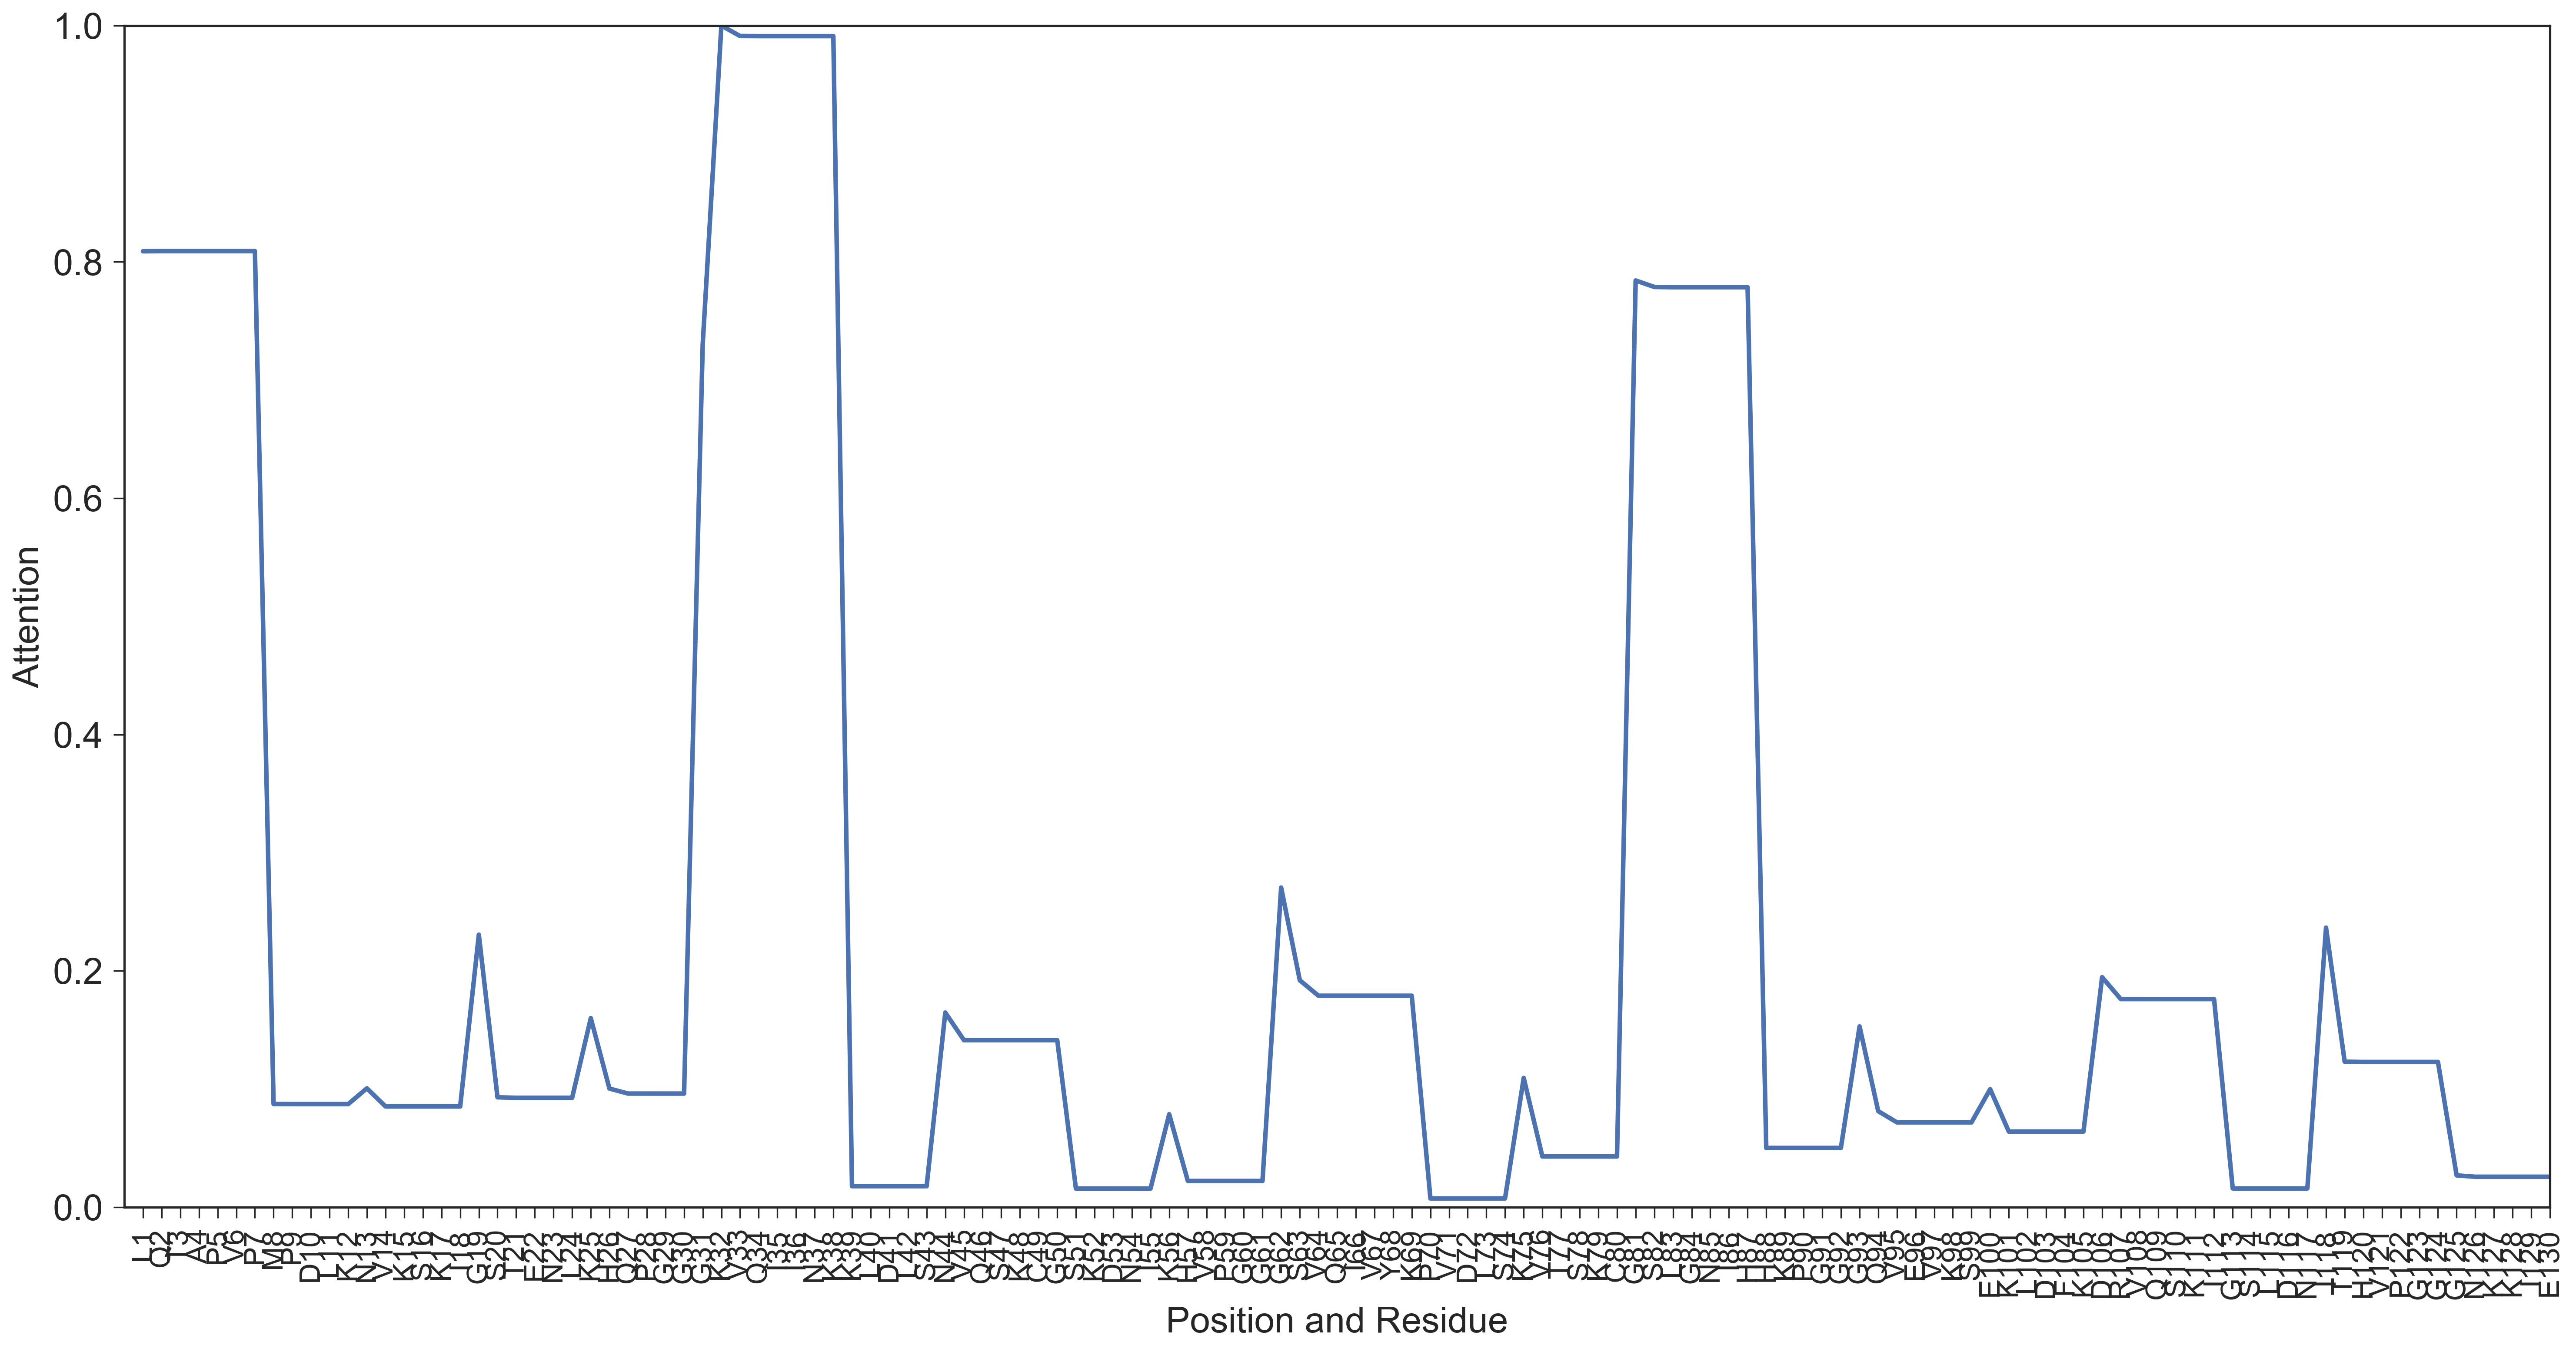

In [8]:
# Activation Plot
START=1
SEQ_LENGTH=attn1.shape[0]
RES=[consensus]
nums = numpy.arange(0,SEQ_LENGTH,1);
xticks = [(RES[0][i-START]+str(int(i))) for i in range(START,SEQ_LENGTH+START)]
seaborn.set_style("white")
seaborn.set_style("ticks")
seaborn.set_context("paper",rc={"lines.linewidth": 2.5})
 
 
f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax = seaborn.tsplot(data=[attn1]);
ax.set_ylabel("Attention", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)


(0, 1)

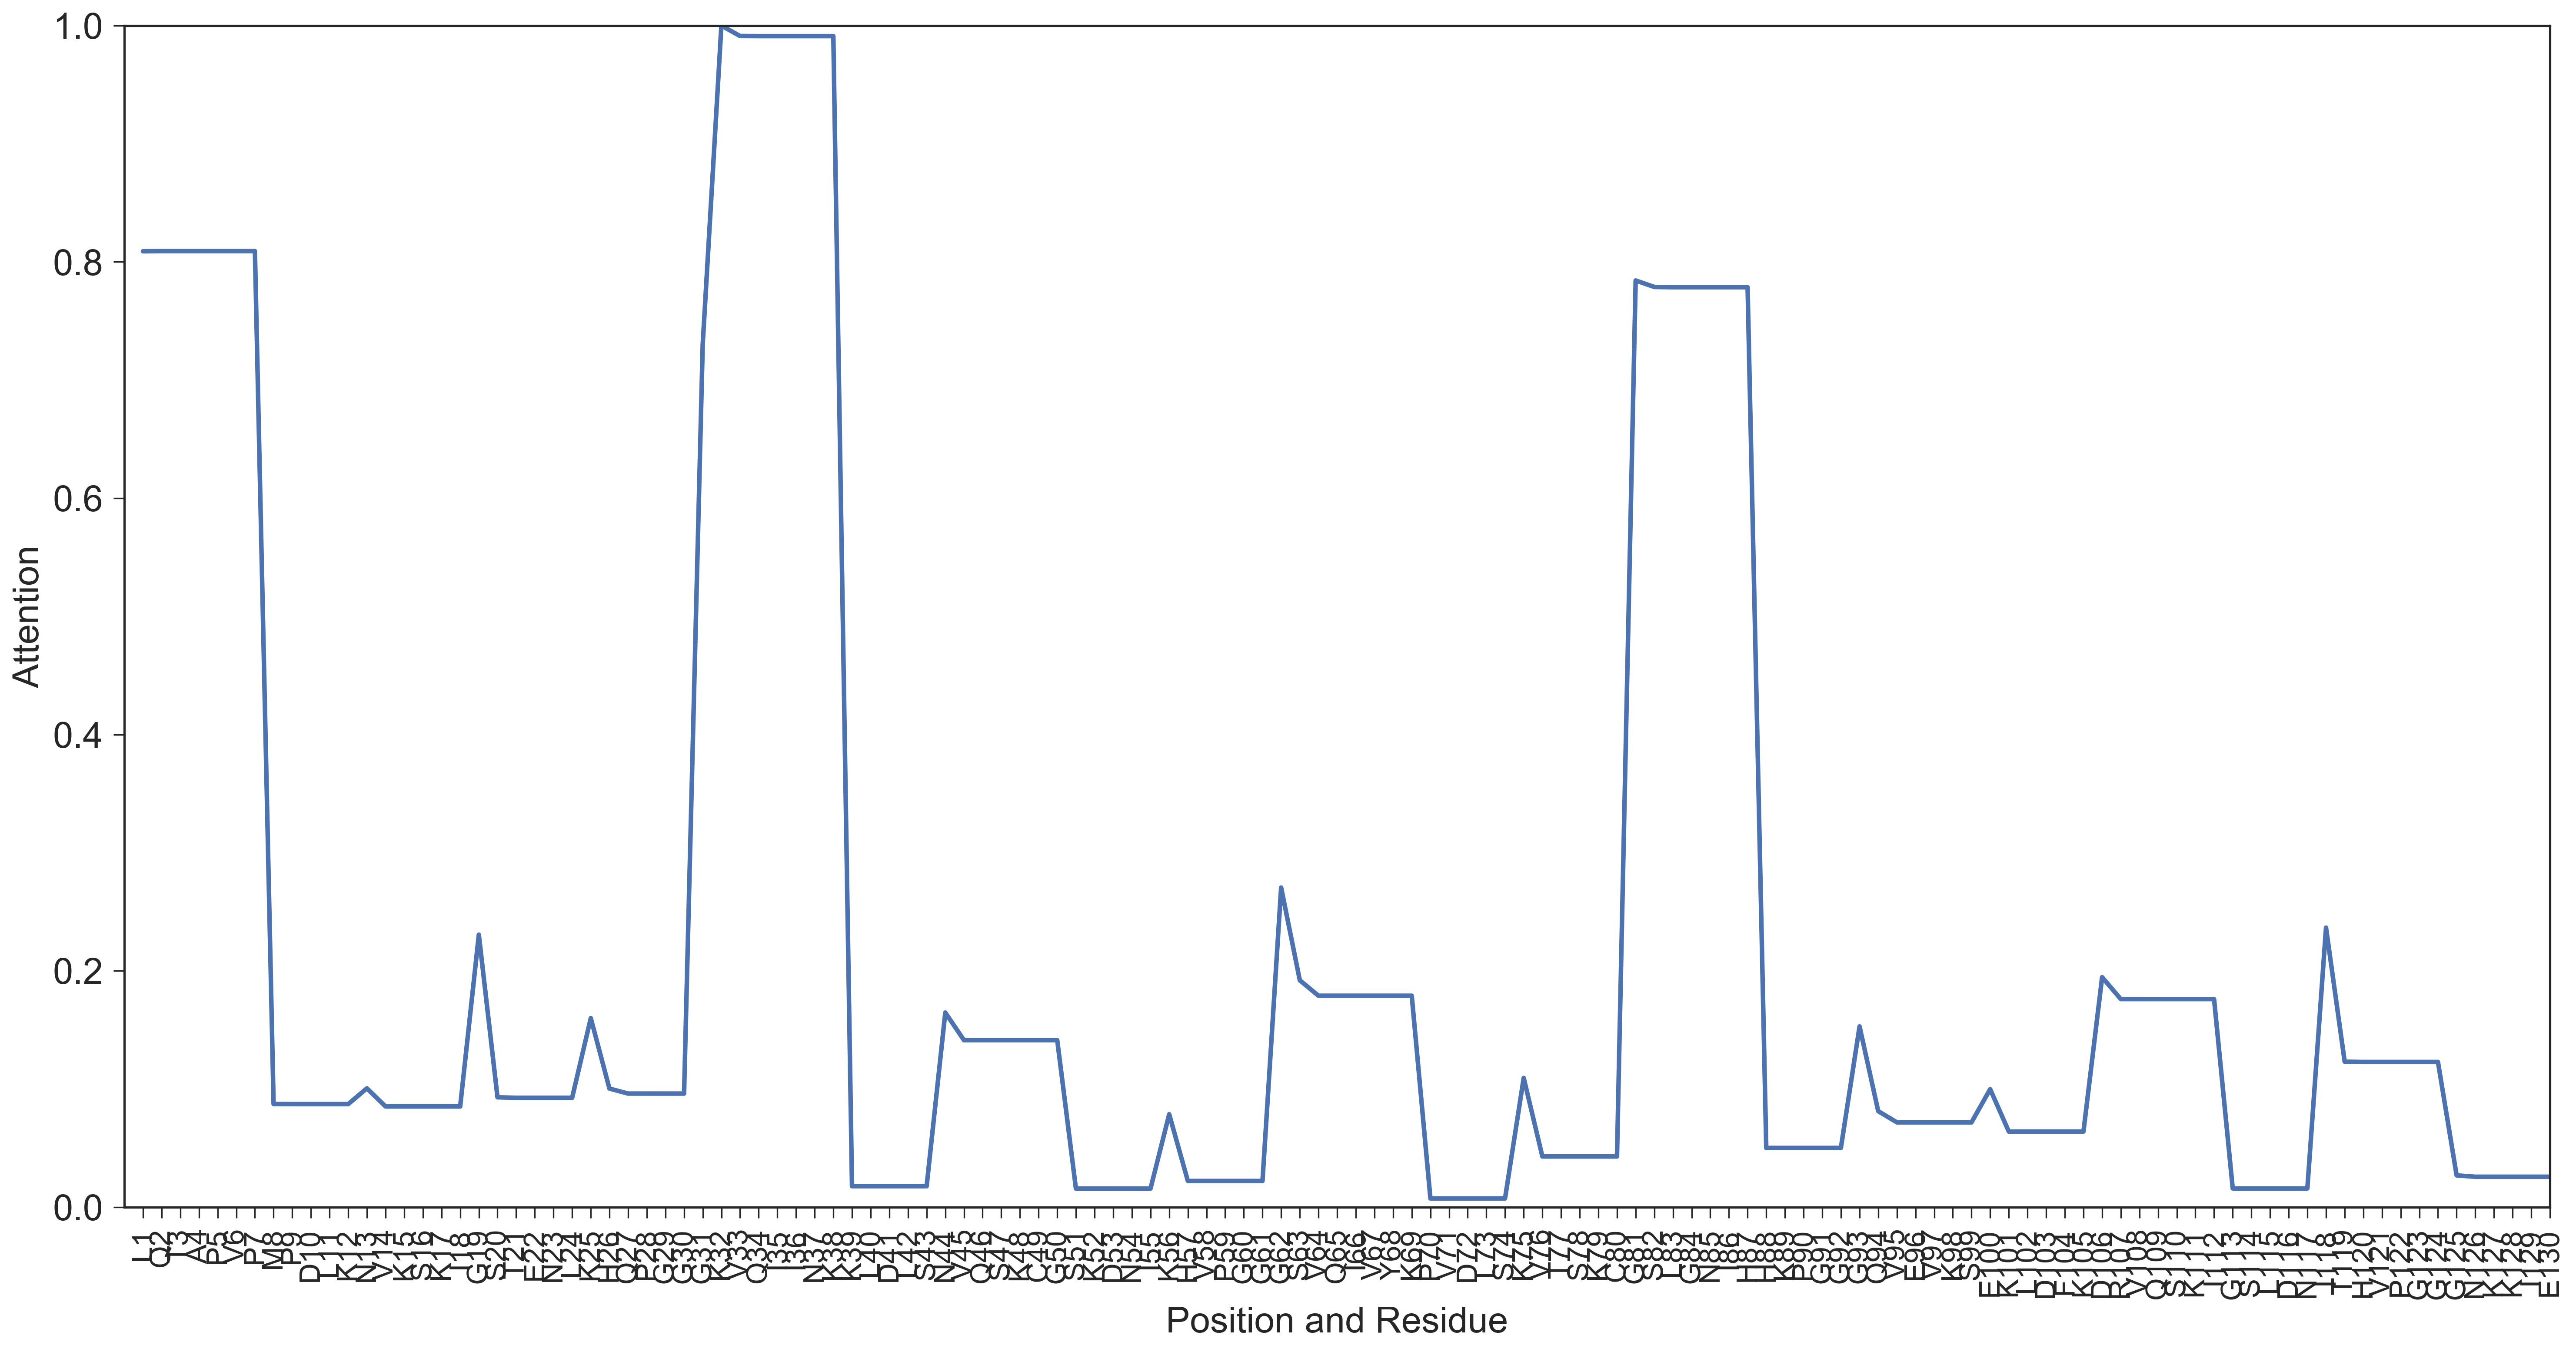

In [9]:
# Sequence Logo
compdata = numpy.mean([attn1], axis=0)
data=normalize(attn1.reshape((1,attn1.shape[0])),norm='max')#,

# data=numpy.mean(data,axis=0)
data_=attn1
data2 = numpy.tril(data_)

# seq_dict = numpy.arange(SEQ_LENGTH)
# dictionary = dict(zip(list(seq_dict), data_))    
# draw_logo(SEQ_LENGTH,RES[0],data_, 'Arial')

# Normalize Attn array
f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax = seaborn.tsplot(data=compdata);
ax.set_ylabel("Attention", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)


(0, 1)

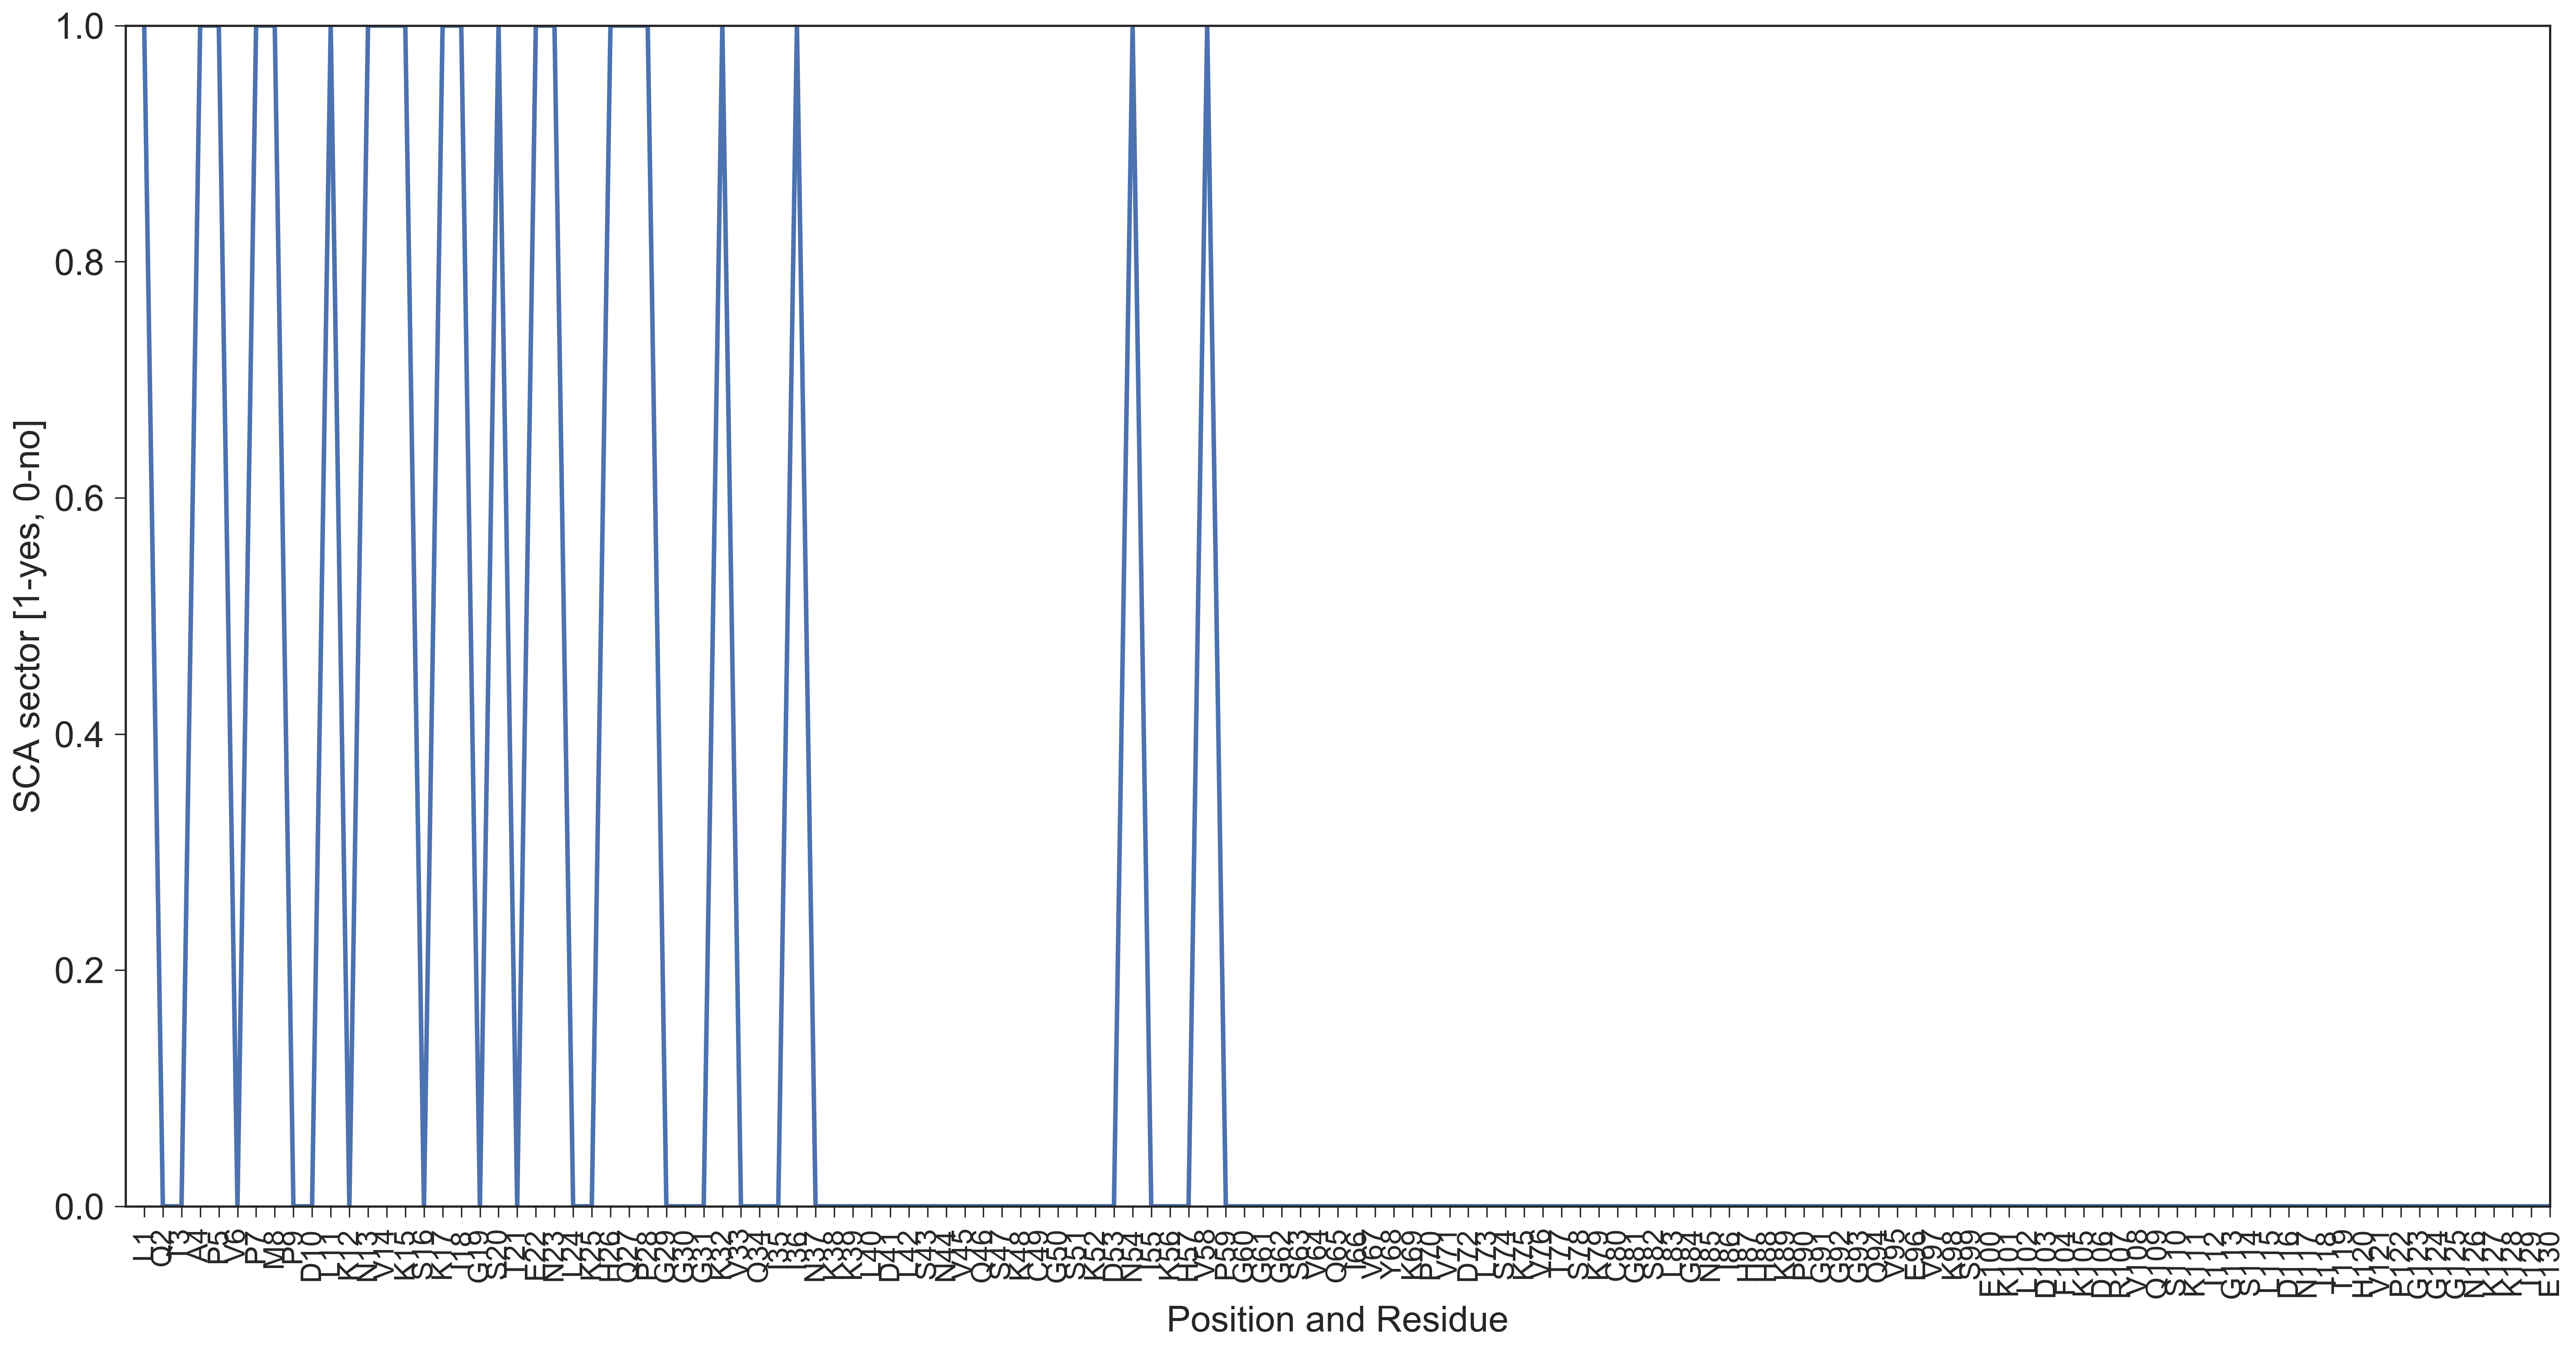

In [10]:
sca_resi = [0,3,4,6,7,10,12,13,14,16,17,19,21,22,25,26,27,31,35,53,57]

seaborn.set_style("white")
seaborn.set_style("ticks")
seaborn.set_context("paper",rc={"lines.linewidth": 2.5})
sca_attn = numpy.zeros(SEQ_LENGTH)
for i in range(0,len(sca_resi)):
    sca_resi[i] = sca_resi[i]-0
    sca_attn[sca_resi[i]] = 1


# Activation Plot
f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax = seaborn.tsplot(data=sca_attn);
ax.set_ylabel("SCA sector [1-yes, 0-no]", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)


(0, 1)

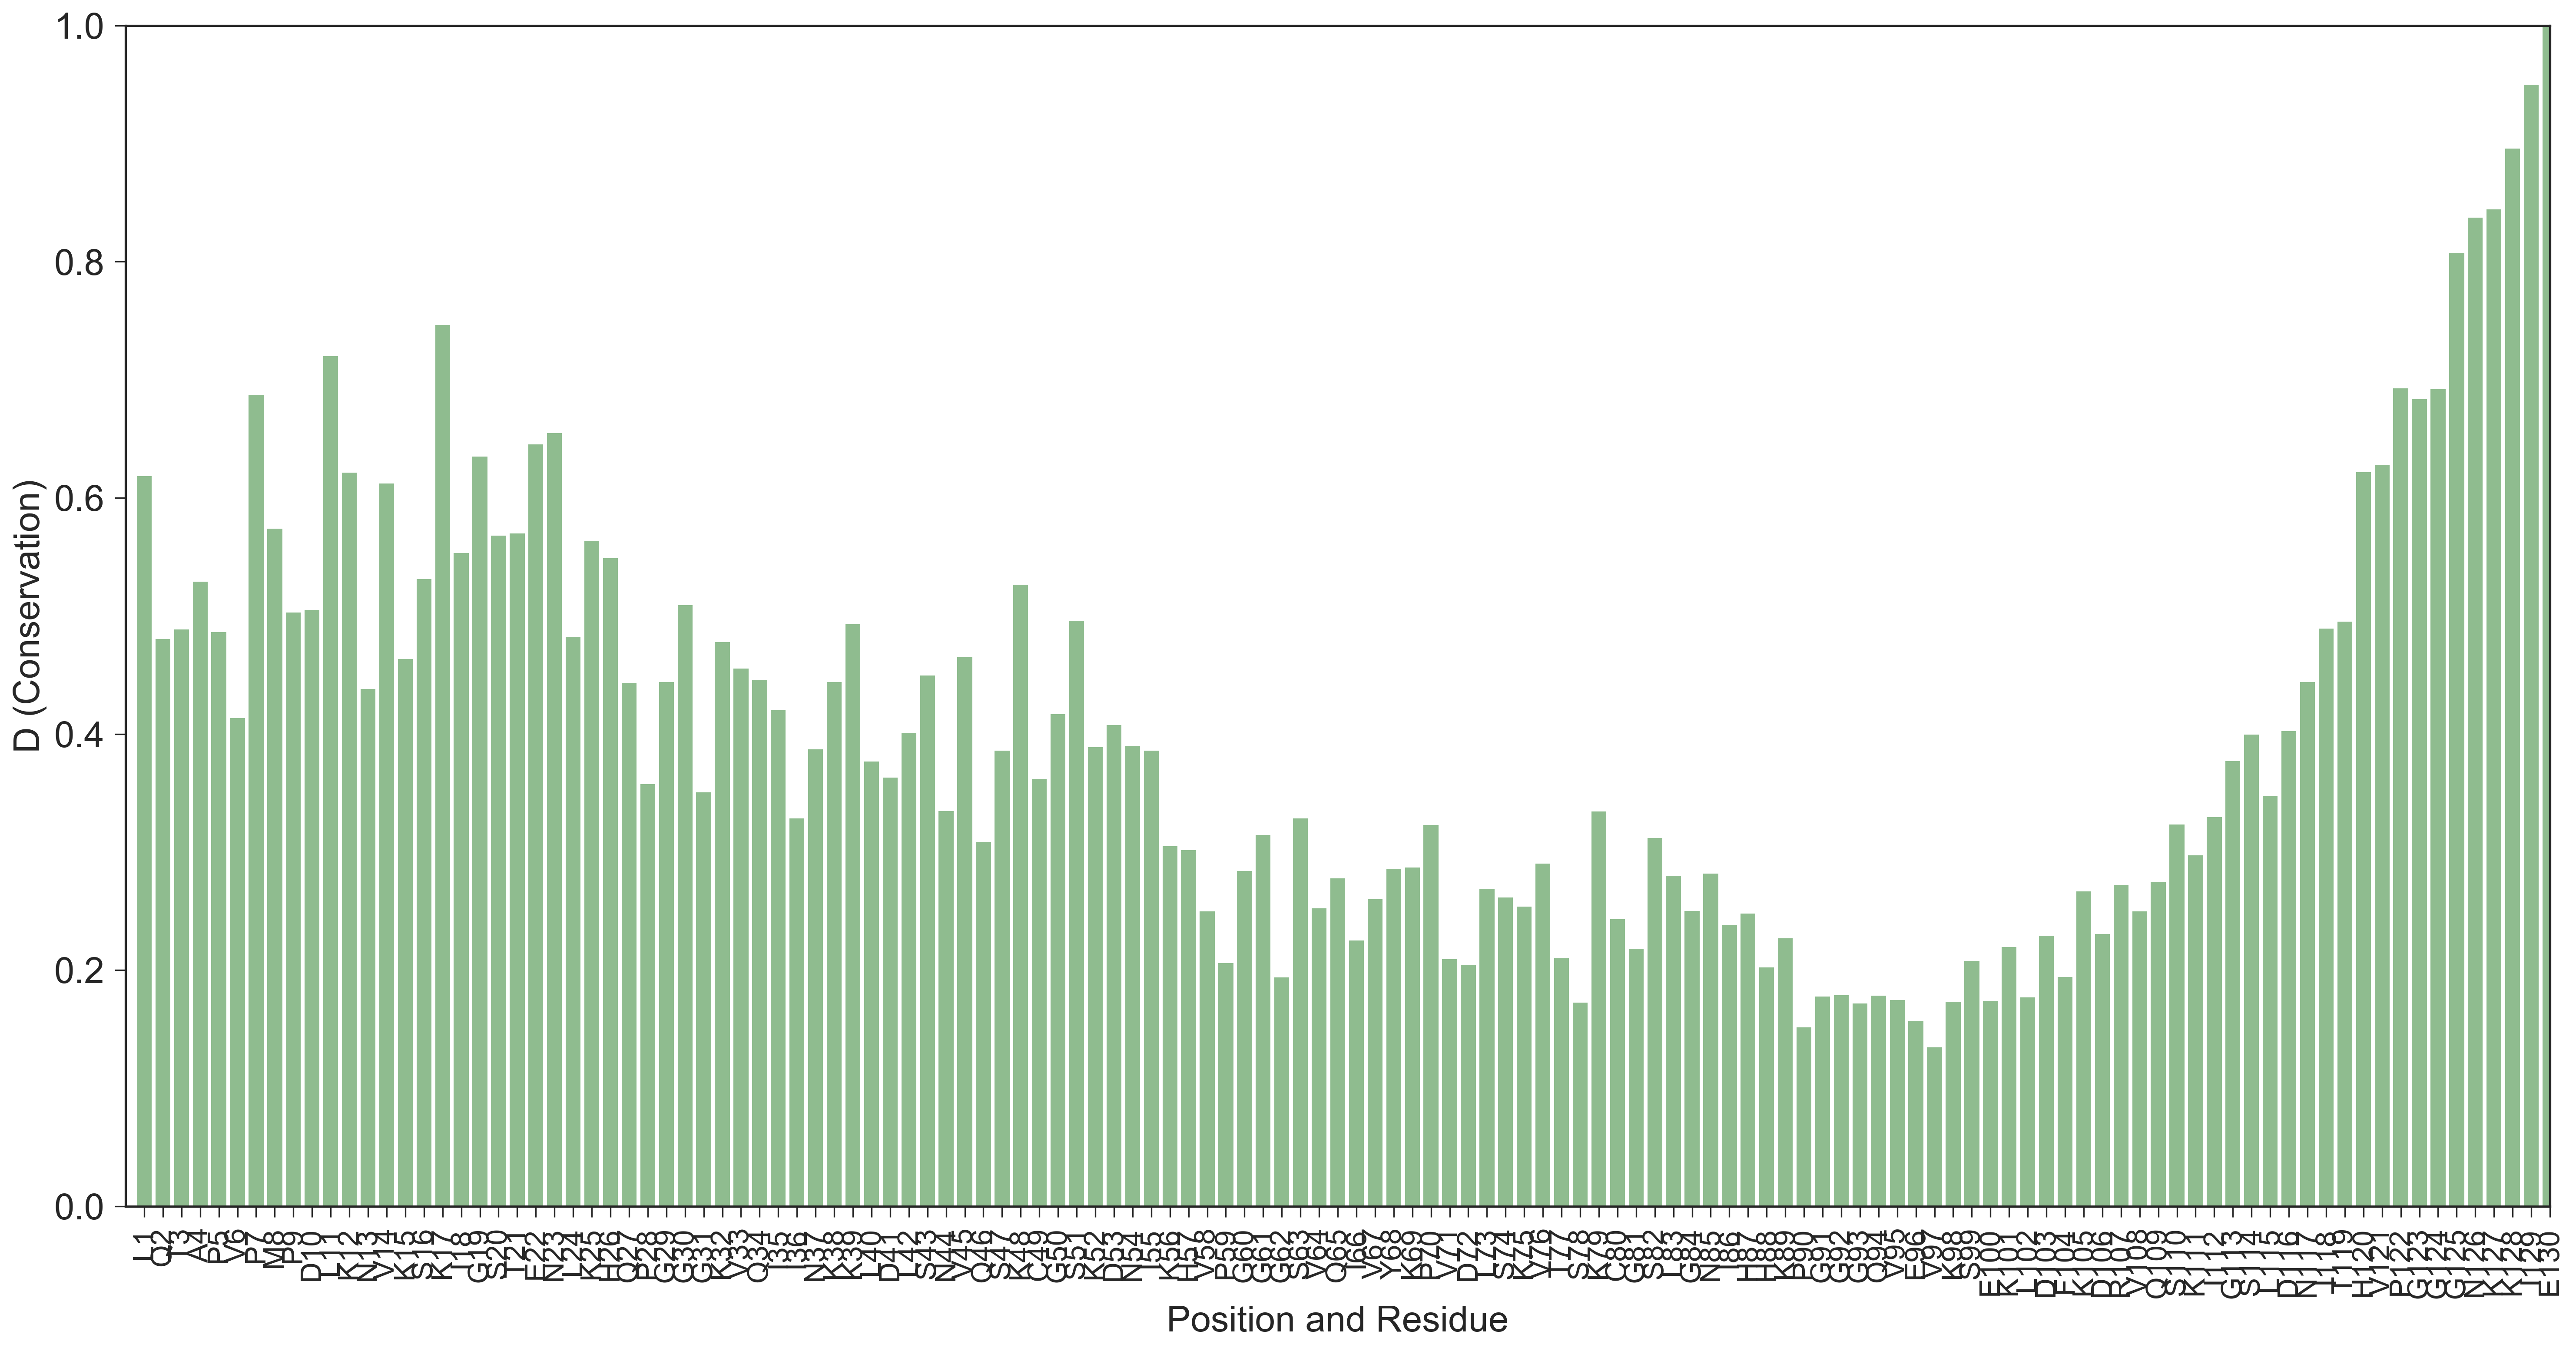

In [11]:
# Conservation
#  A global measure of conservation is similarly measured by D(f(i)||q') (where q' takes into
# account gaps, see Note 103, Section III.D)
D_glo =numpy.asarray([0.657030729777318,0.510565670502080,0.519118032746501,0.561995919765570,0.516703728238451,0.439338000117803,0.730265337486869,0.609810417216254,0.534452086881906,0.536562859851998,0.765263225889840,0.660191951797283,0.465412539863298,0.650714512271705,0.492721584749830,0.564503270458295,0.793149003909265,0.587807431794216,0.674778561094091,0.603552346551565,0.605469632359858,0.685679480653094,0.695929495090382,0.512343580182073,0.598965662115907,0.583160770007664,0.470876653386485,0.379939093260553,0.471705674564152,0.541085873517344,0.372622693490834,0.507964275095505,0.484077785312558,0.473744700085731,0.446409058808321,0.349186440671008,0.411294112122058,0.471933812219936,0.523672718770883,0.400245776632443,0.385822361618474,0.426001693167398,0.477679558557810,0.355561054756991,0.494215730550691,0.328101246976406,0.410119273326015,0.559619152648998,0.384562517176775,0.443093407909354,0.527106042481532,0.413214767029434,0.433001239487607,0.414352644438901,0.410164102249773,0.324036664135259,0.320636265616296,0.265250156756389,0.219026952439917,0.301584051517327,0.334218436619285,0.206087665455755,0.349262802997482,0.268021935583897,0.295303432878475,0.239078141923609,0.276267900614653,0.303705072911463,0.305045992637060,0.343130504529260,0.222234142204950,0.217486392376657,0.285795362279179,0.277931438852453,0.269744036372983,0.308617721937152,0.223149852680892,0.183329714892634,0.355481242927728,0.258376895861902,0.231809347099034,0.331421026274681,0.297343839010833,0.265640847449261,0.299609259674785,0.253222729683811,0.263435868861436,0.214954067810922,0.241281771615426,0.160881811618860,0.188697097371900,0.189814348817086,0.182484218289904,0.189427879619046,0.185554698926743,0.166932739958844,0.143203936593035,0.184234988951779,0.220881010911993,0.185020122857230,0.233201114024468,0.187942768731917,0.243491287080718,0.206307057006017,0.283235870468192,0.245283588464822,0.289210764210090,0.265352006977135,0.292171284573064,0.343602474214127,0.315698109452594,0.350263024645300,0.400657224176441,0.424493003538793,0.368942992640025,0.427600462736530,0.471681341646784,0.519960660867557,0.526038639782566,0.660799235297755,0.667145751622955,0.736272632385746,0.726555448298407,0.735525681166713,0.857933314535216,0.889778705094677,0.897117758453327,0.952140272214664,1.00935922975456,1.06265322837636])
D_glo = normalize(D_glo.reshape(-1, 1),norm='max',axis=0).ravel()

f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax1 = ax.bar(nums,D_glo, color='darkseagreen');
ax.set_ylabel("D (Conservation)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

F1: 0.6307692307692307 ROC AUC: 0.5372670807453417


(0, 1)

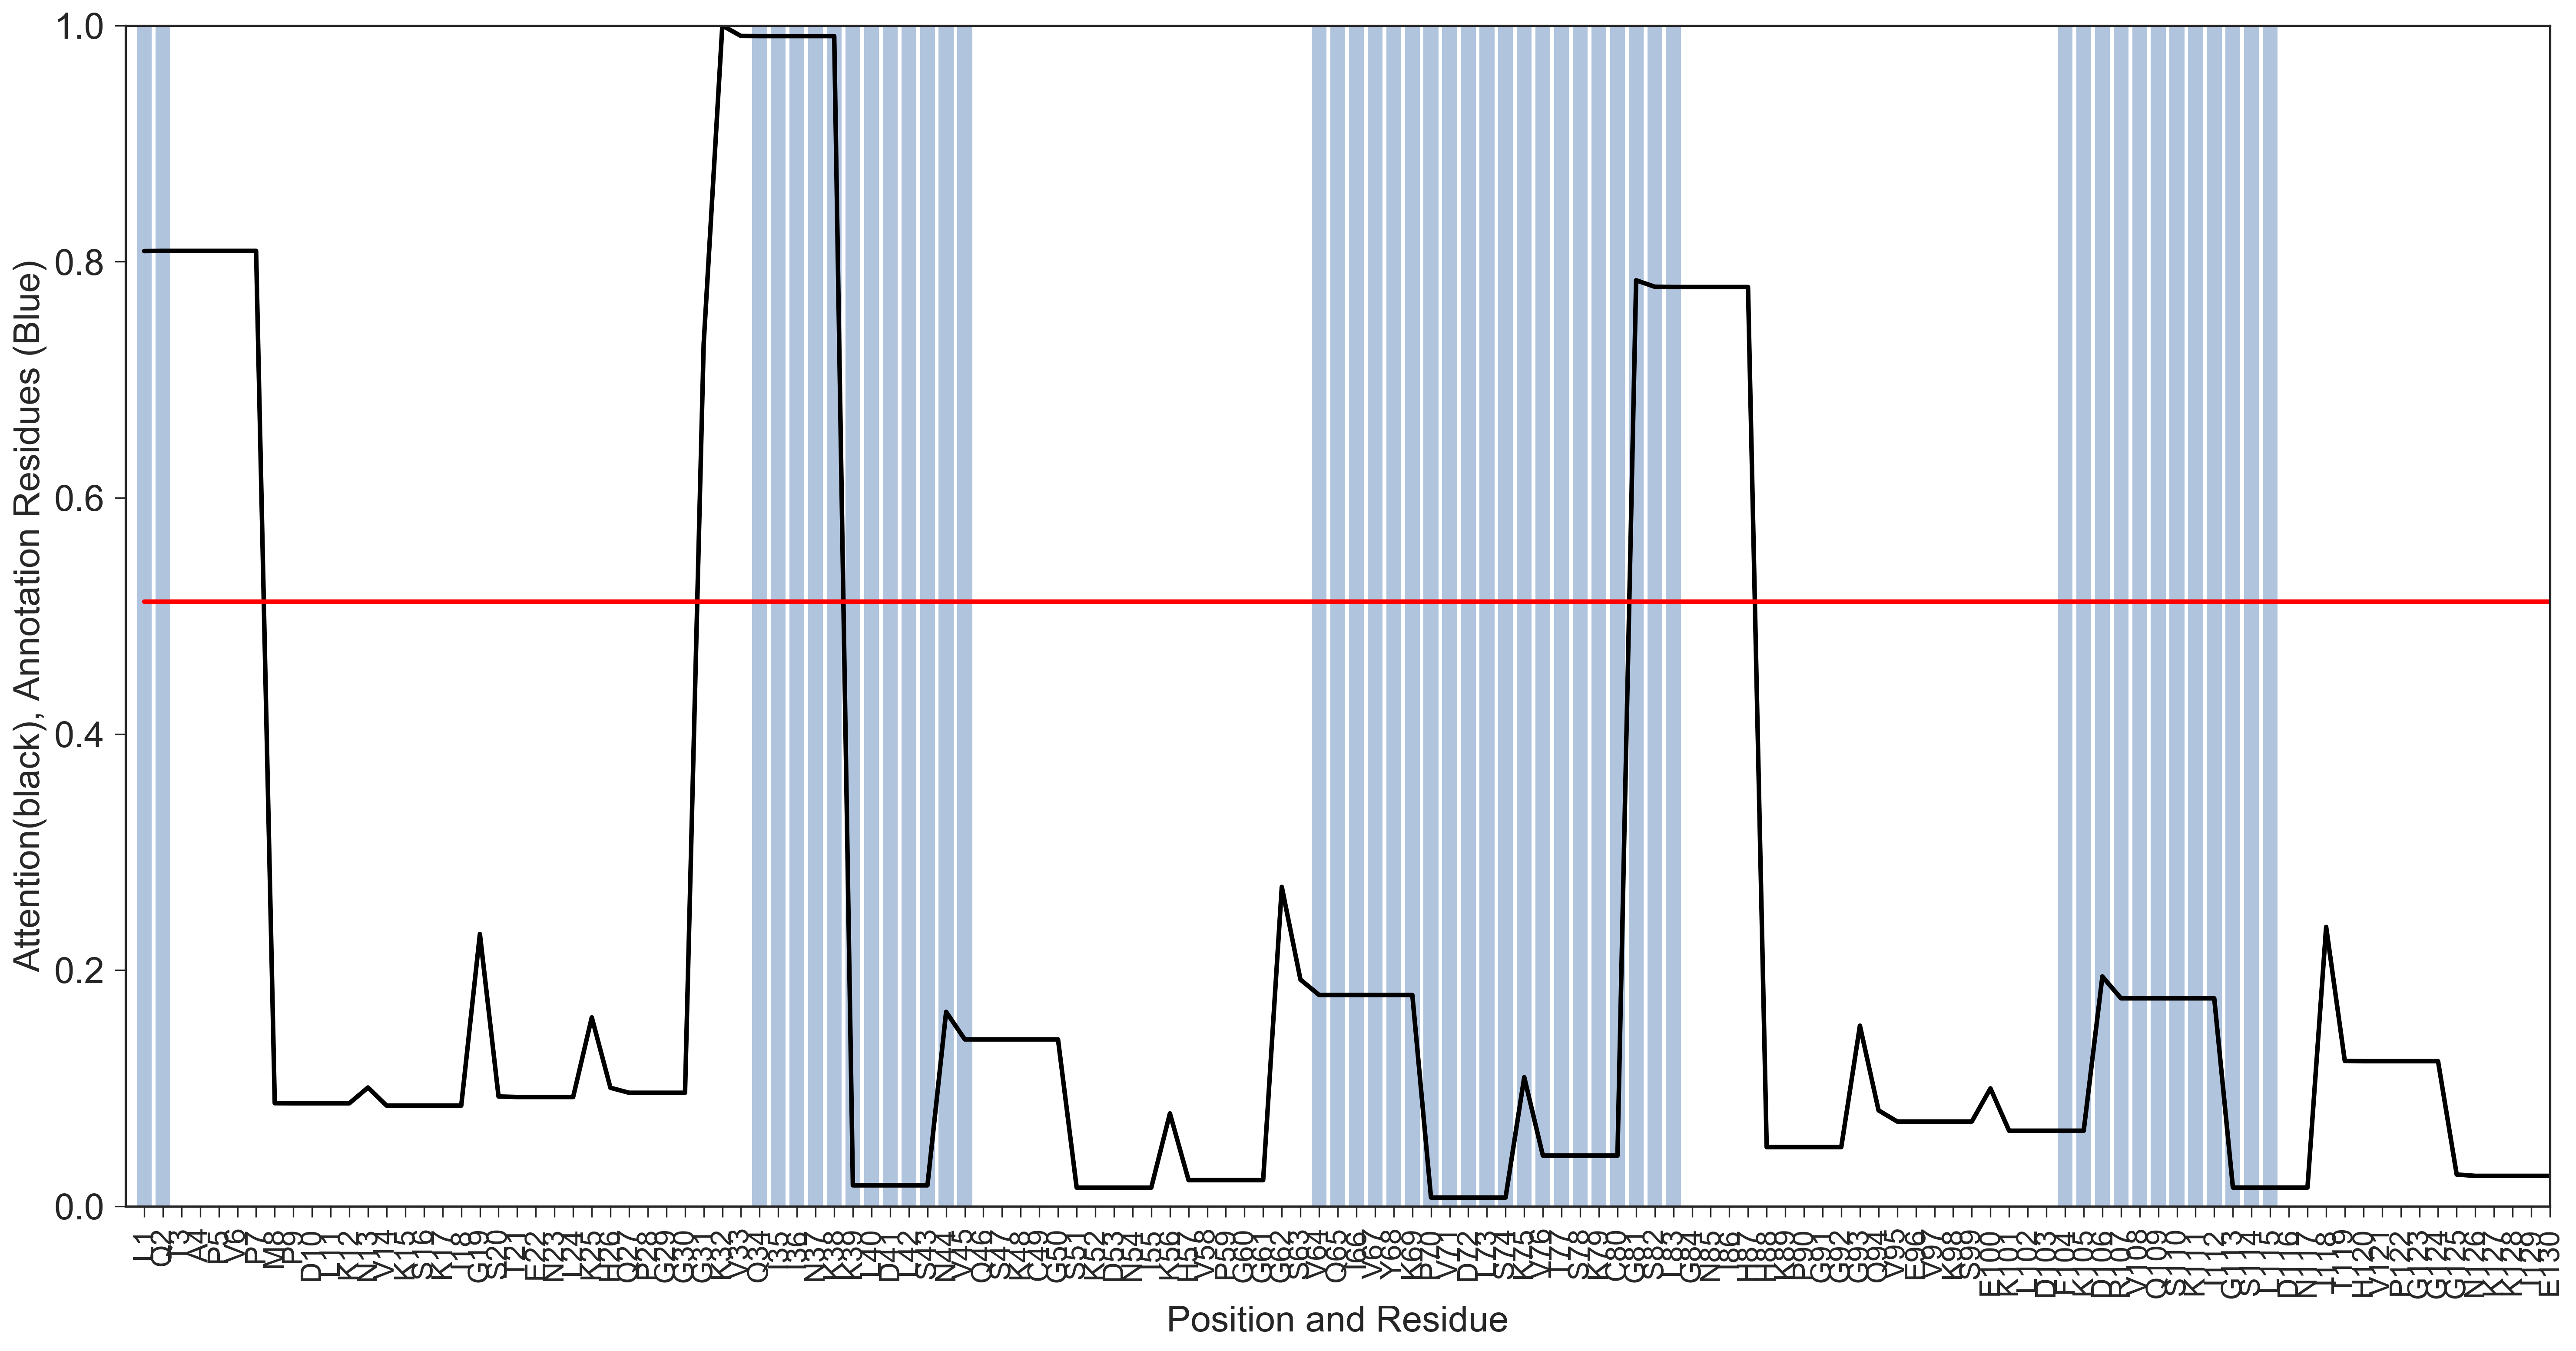

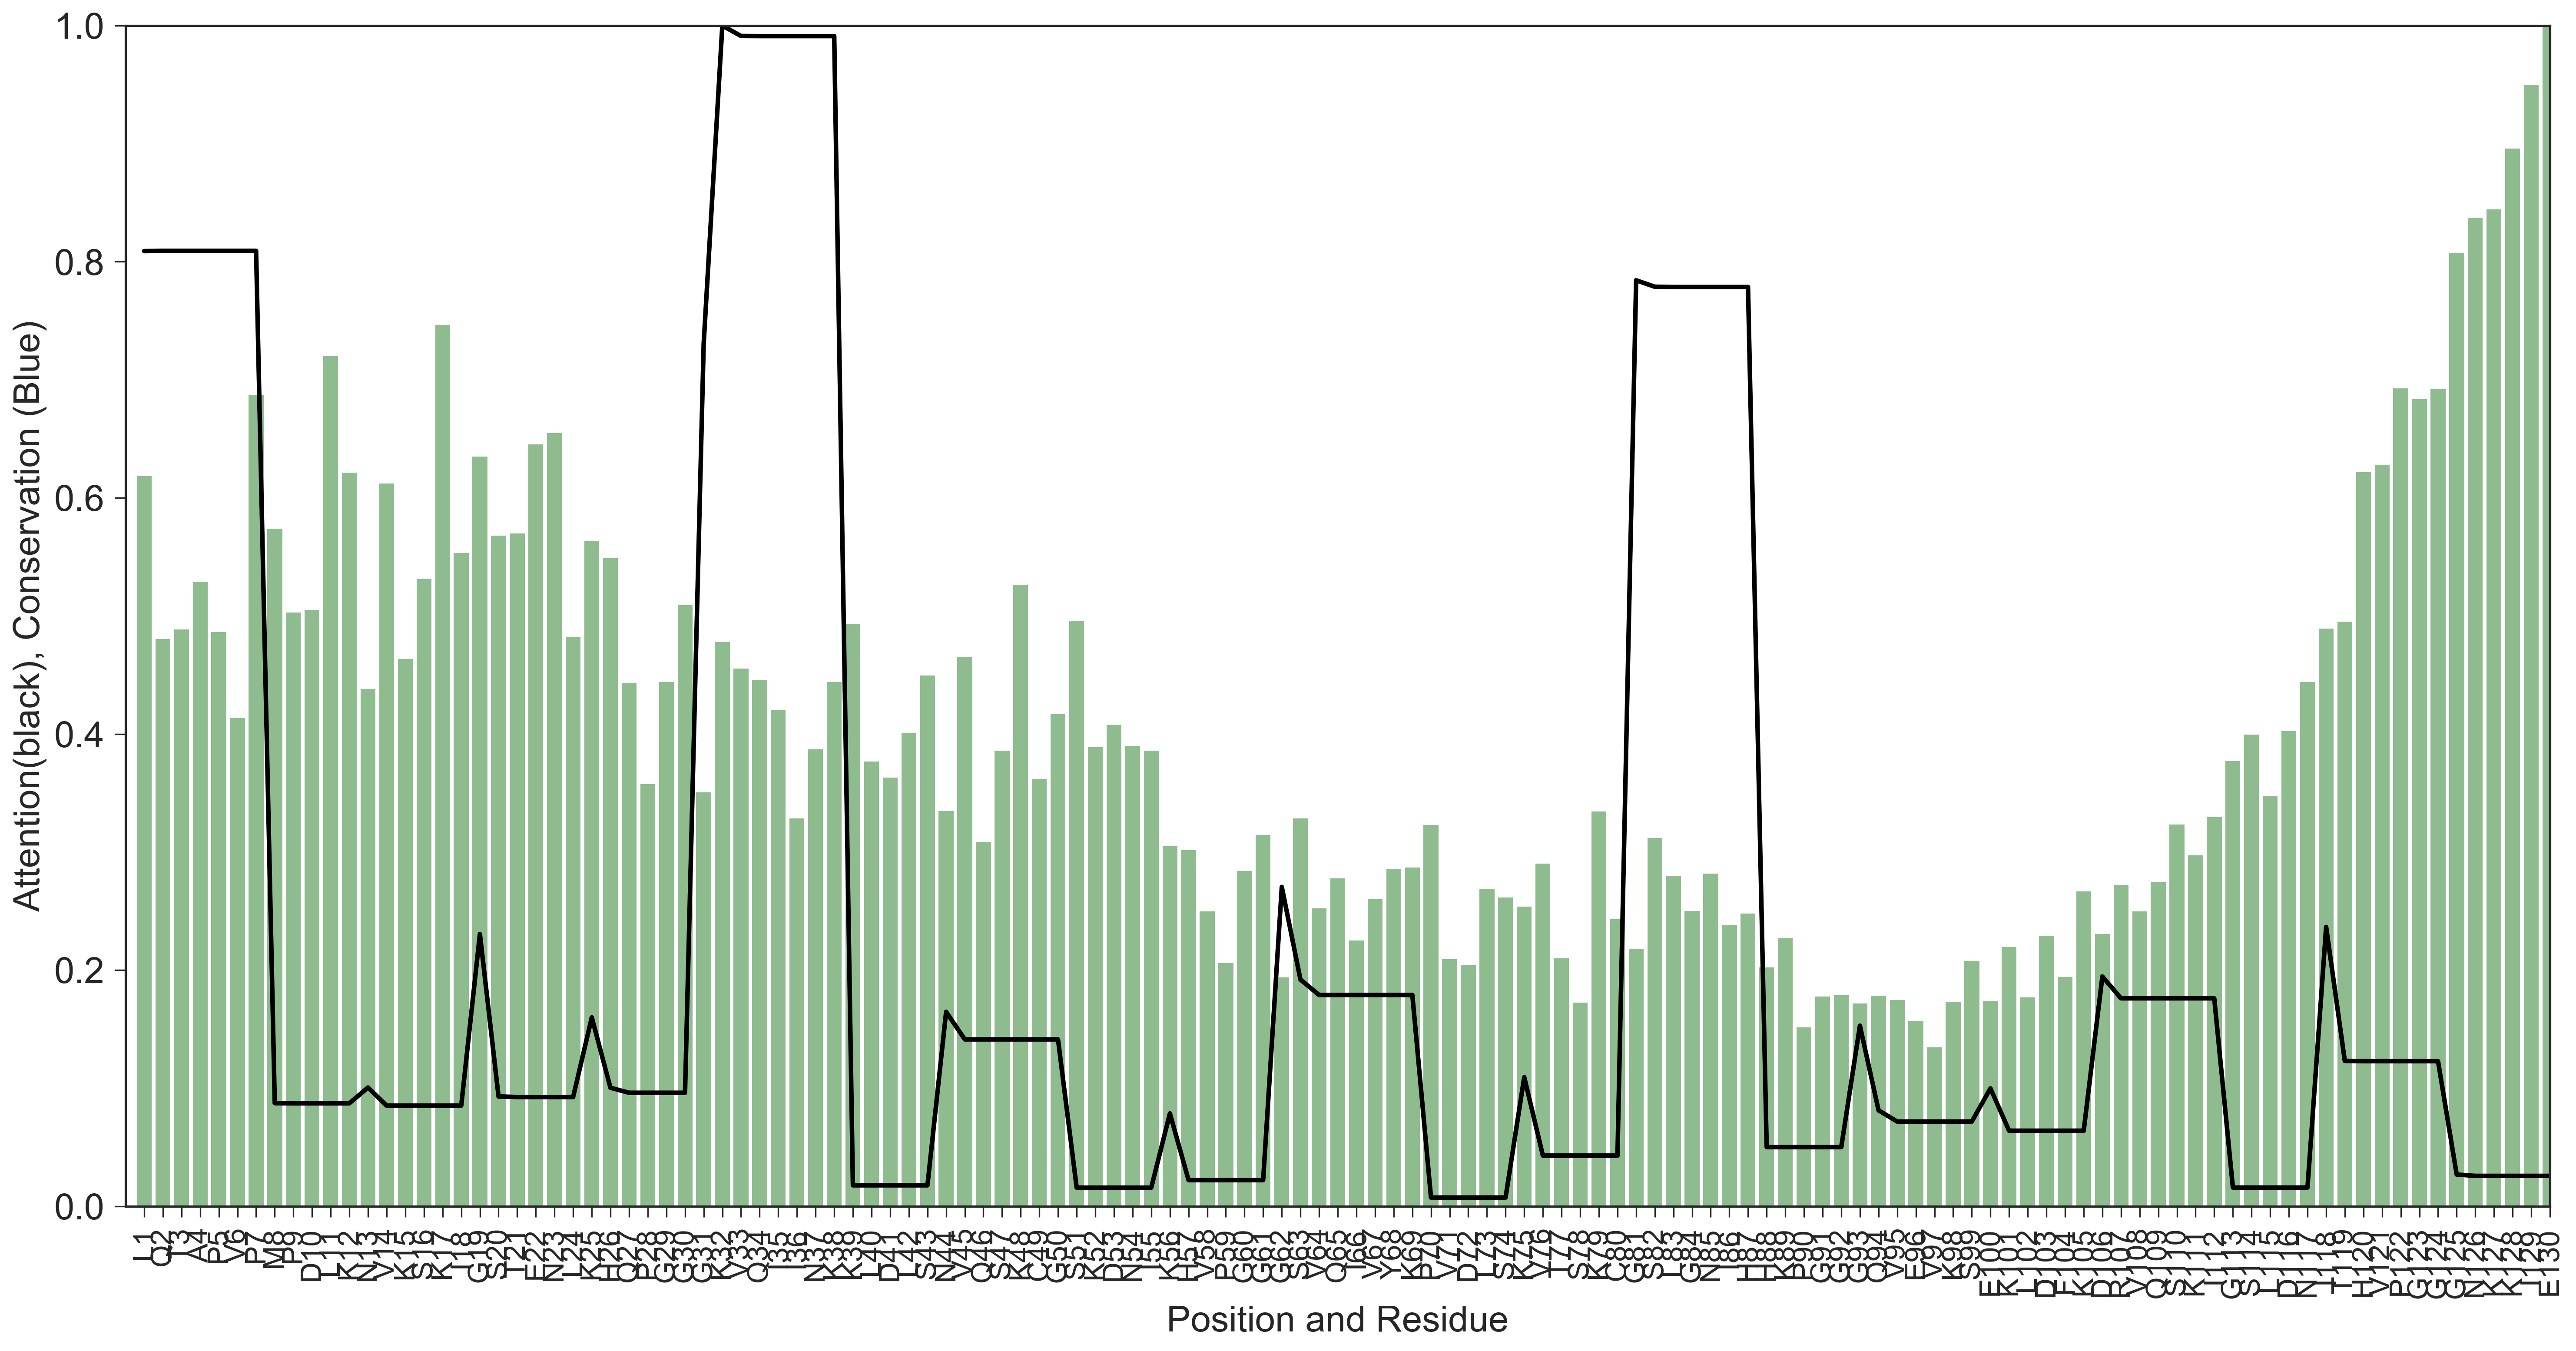

In [12]:
from sklearn import metrics

y = numpy.array([1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
dataauc=attn1
# Make attn = 1 if >0.1
y_ = numpy.zeros(SEQ_LENGTH)
y_ =[1*(dataauc[i]>(numpy.mean(dataauc)+1*numpy.std(dataauc))) for i in range(0,SEQ_LENGTH)  ]

seq_dict = numpy.arange(SEQ_LENGTH)

data_auc=metrics.auc(nums, y_)
y_auc=metrics.auc(nums, y)
roc_auc = metrics.roc_auc_score(y,numpy.array(y_))
from sklearn.metrics import f1_score
f1=f1_score(y,numpy.array(y_), average='micro')  
print("F1:",f1,"ROC AUC:",roc_auc)

f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = plt.bar(nums,y, color='lightsteelblue');
ax = seaborn.tsplot(data=dataauc, color='black');
ax.set_ylabel("Attention(black), Annotation Residues (Blue)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
threshold = (numpy.mean(dataauc)+1*numpy.std(dataauc))*numpy.ones(SEQ_LENGTH)
ax.plot(seq_dict,threshold, 'r');
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = plt.bar(nums,D_glo, color='darkseagreen');
ax = seaborn.tsplot(data=dataauc, color='black');
ax.set_ylabel("Attention(black), Conservation (Blue)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)


(0, 1)

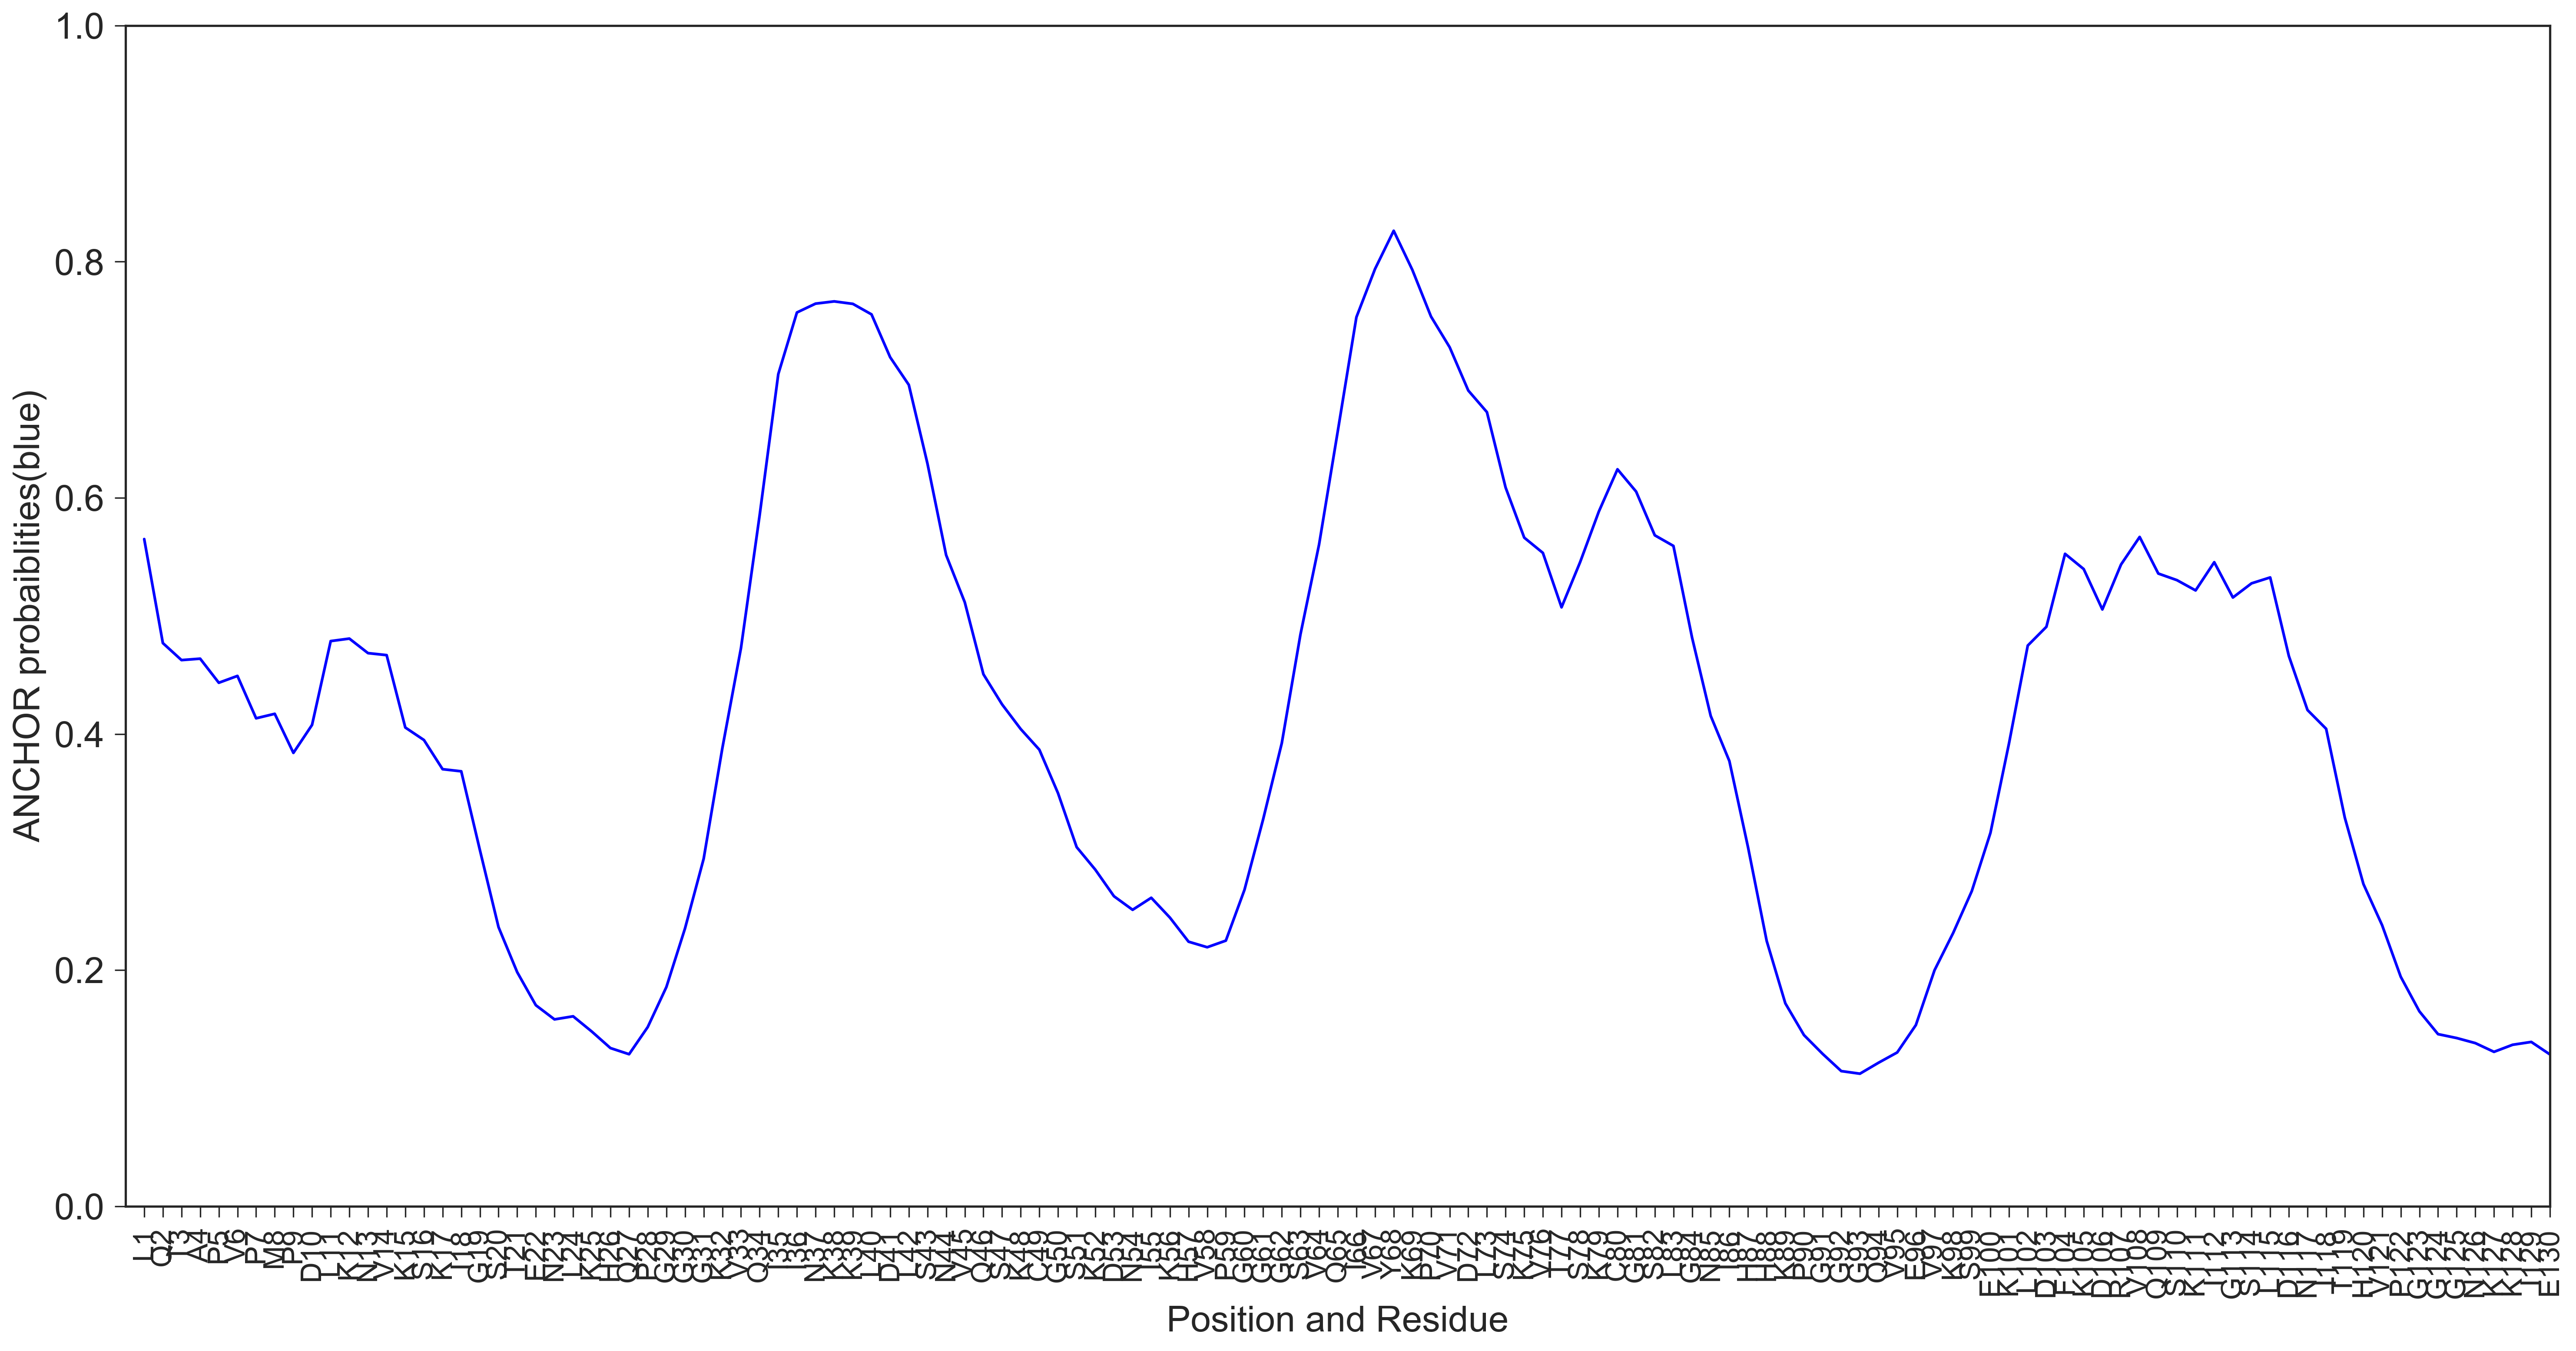

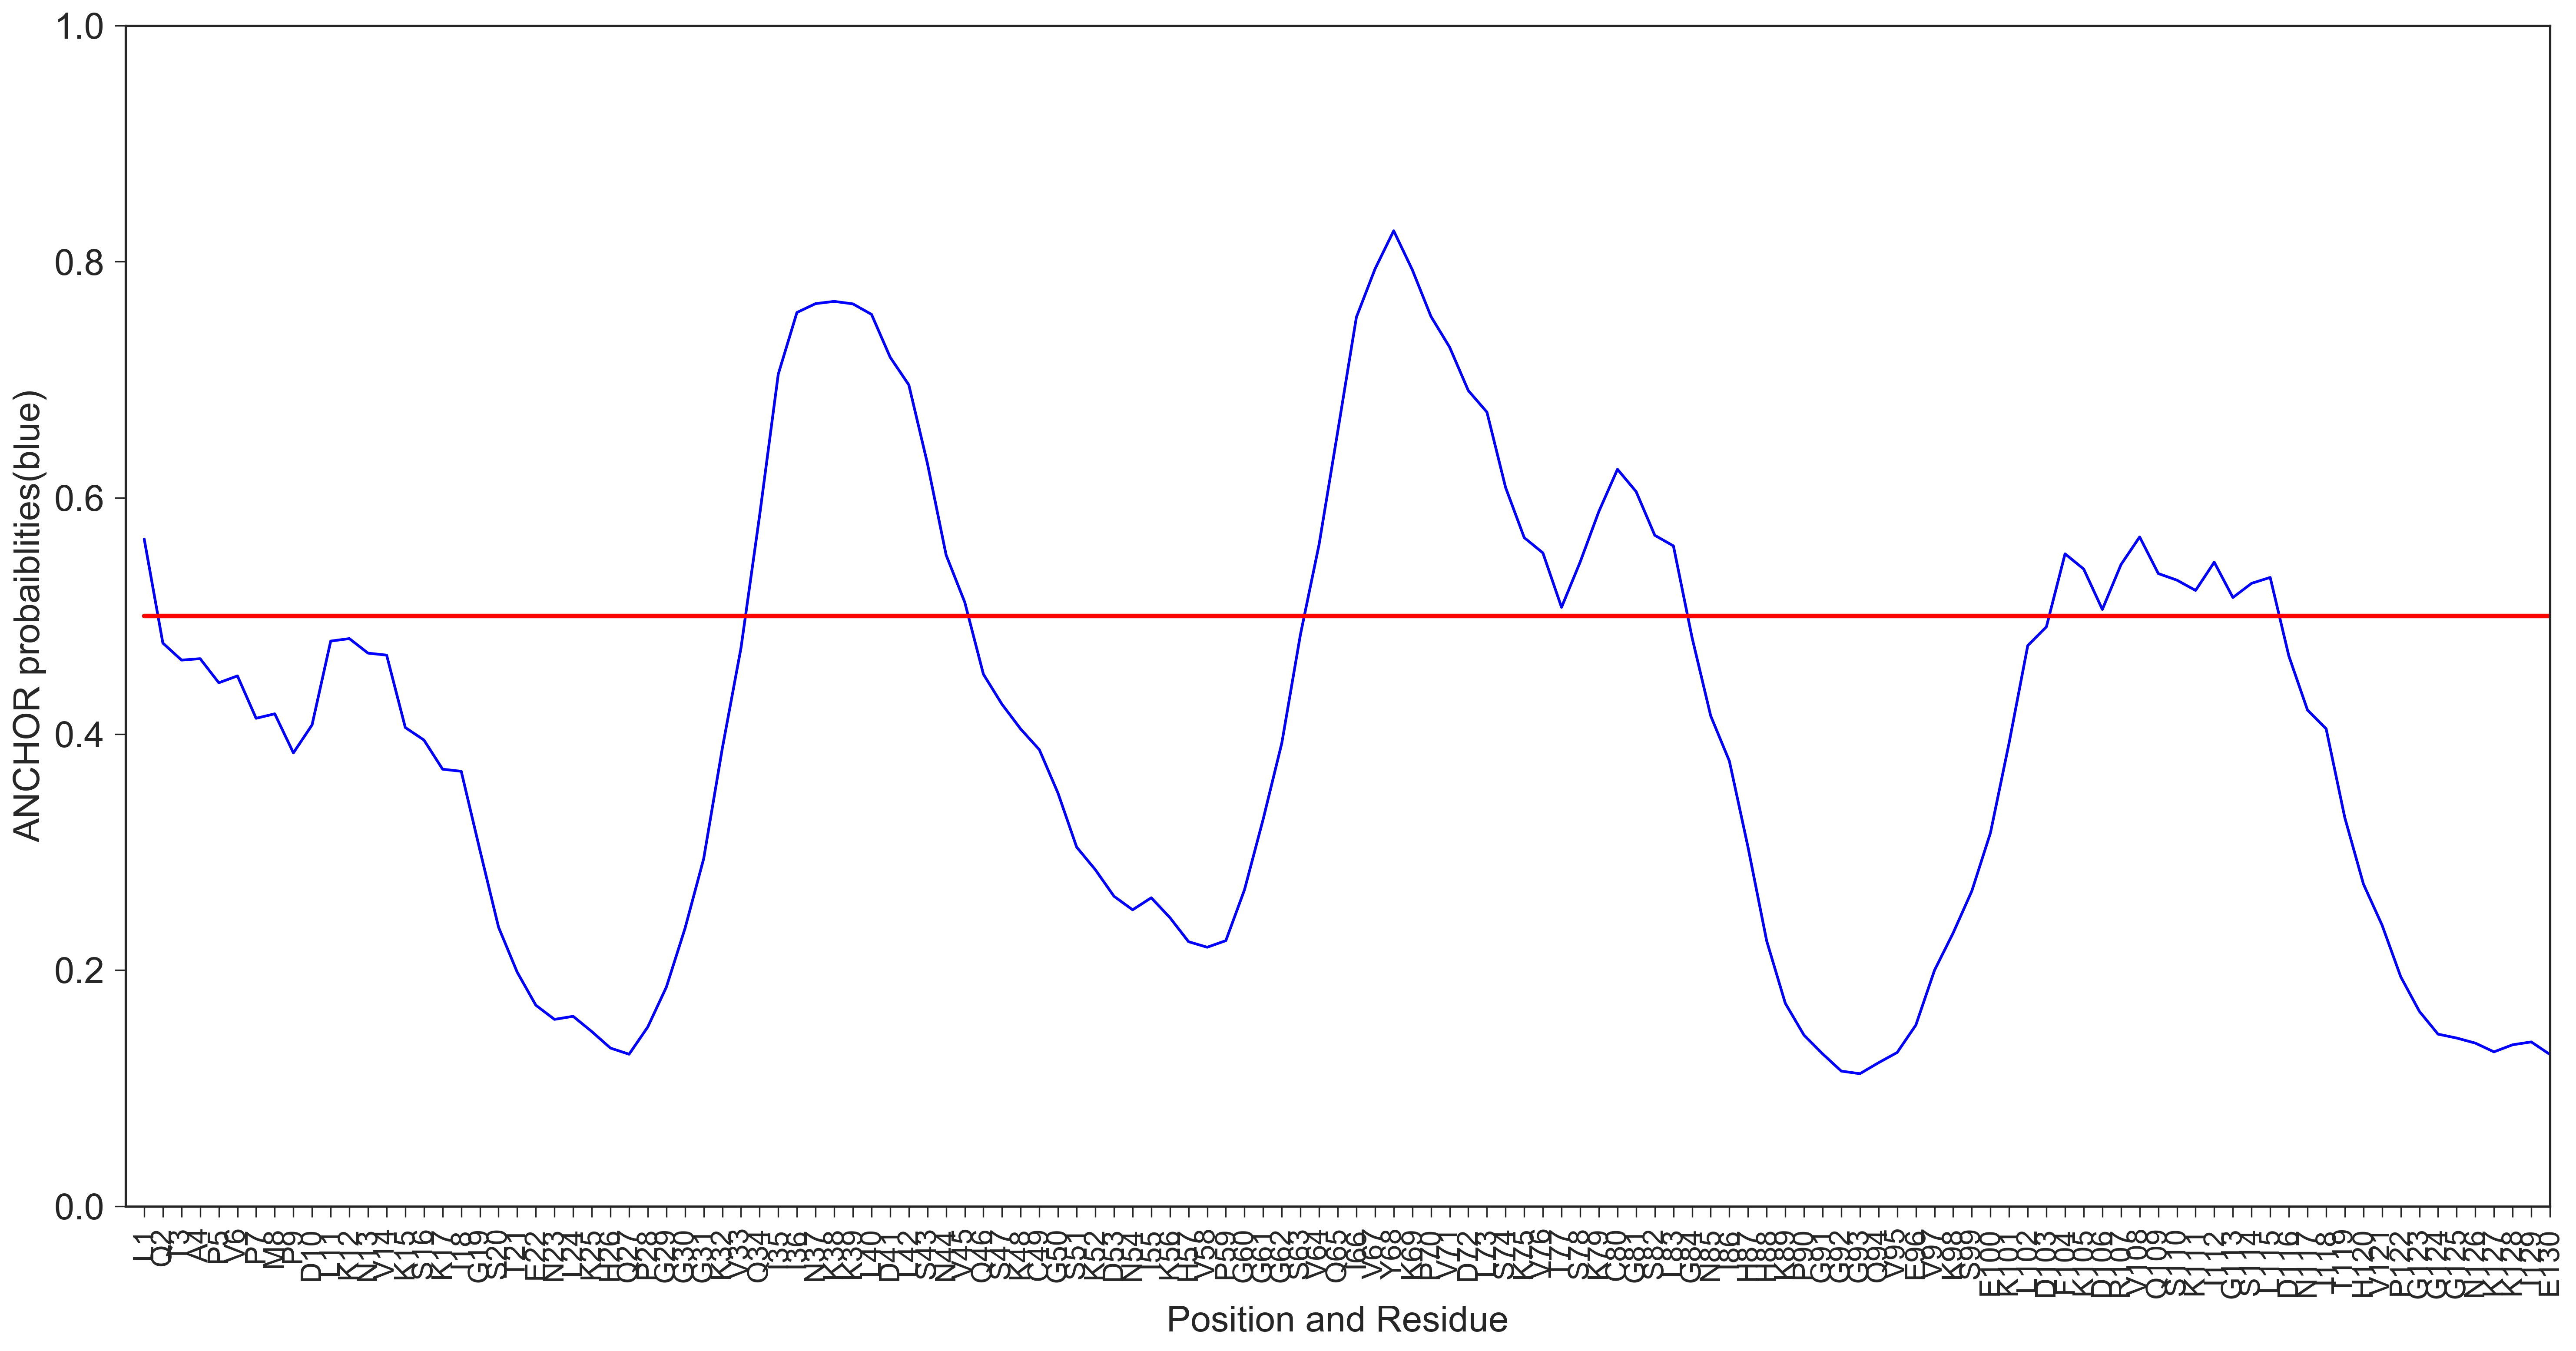

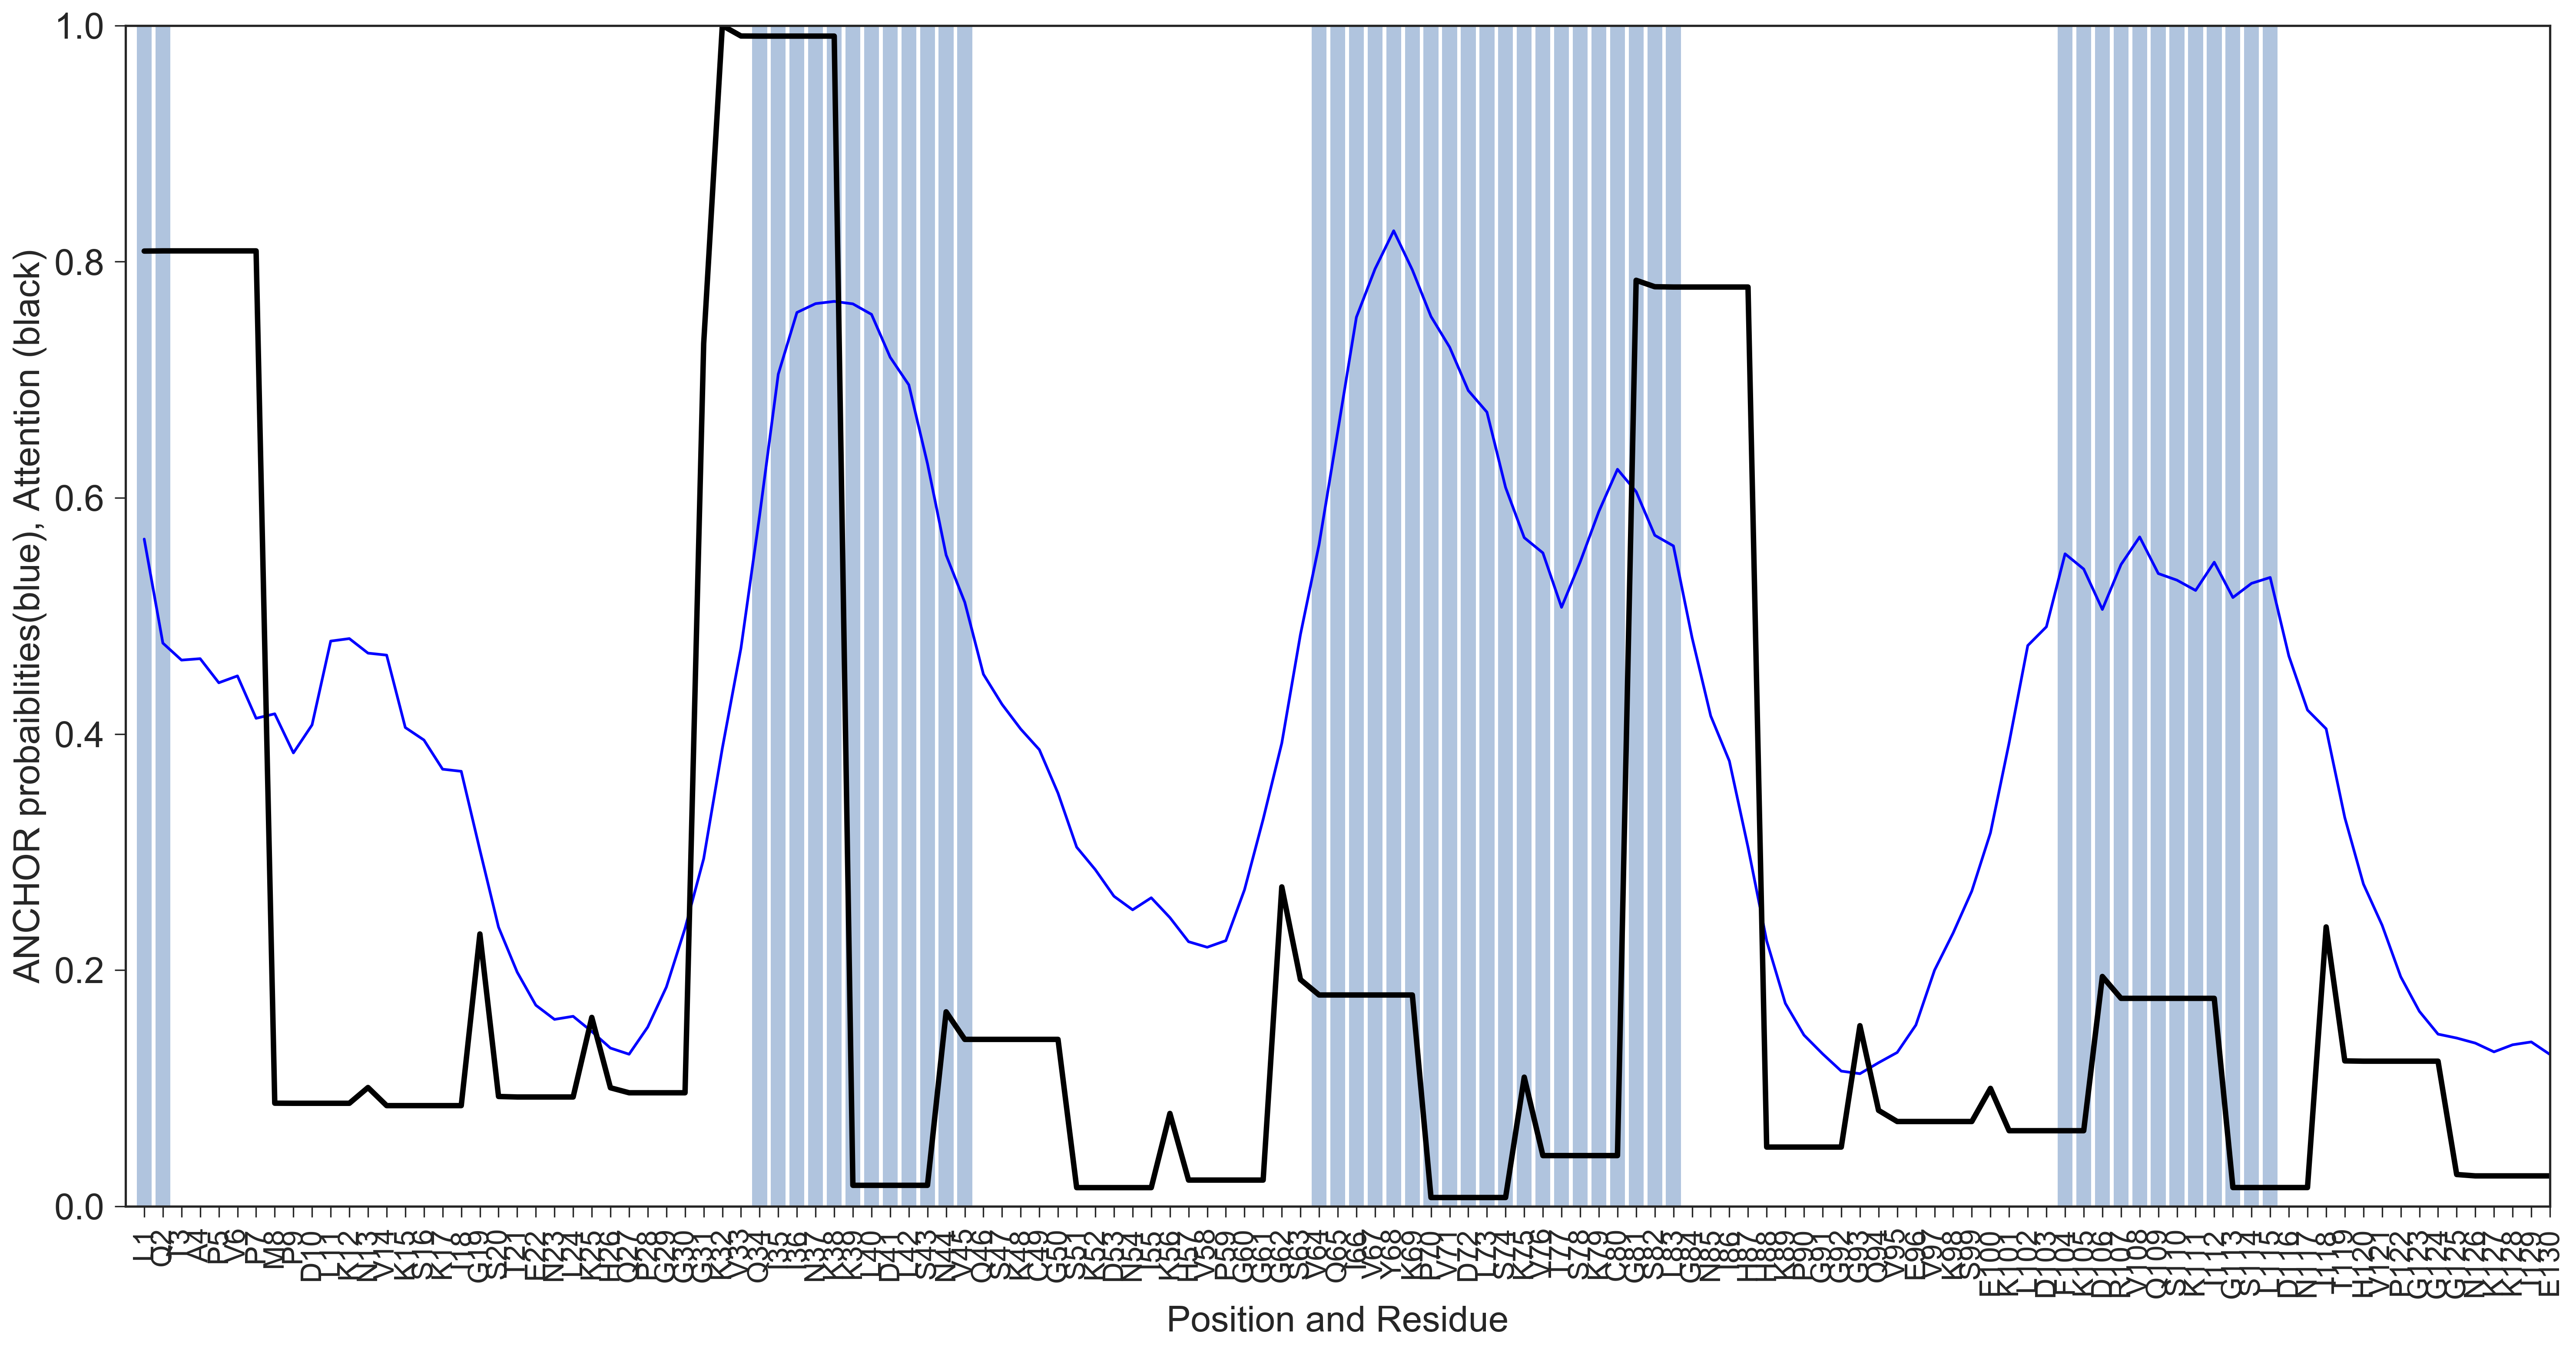

In [13]:
anchor = [0.5651,0.477,0.4626,0.4638,0.4434,0.4492,0.4133,0.4171,0.384,0.4077,0.4787,0.4808,0.4685,0.4668,0.4055,0.3949,0.3702,0.3684,0.3017,0.2364,0.1983,0.1703,0.1583,0.1609,0.148,0.134,0.1288,0.1518,0.1857,0.2354,0.2944,0.3879,0.4728,0.5852,0.7048,0.757,0.7645,0.7664,0.7643,0.7554,0.7191,0.6957,0.629,0.5516,0.5116,0.4506,0.4251,0.4042,0.3867,0.3499,0.3042,0.2851,0.2626,0.2511,0.2613,0.2445,0.2241,0.2194,0.225,0.2681,0.3278,0.3923,0.4843,0.5606,0.6563,0.753,0.7939,0.8262,0.7931,0.7536,0.7276,0.6909,0.6726,0.6088,0.5663,0.5534,0.5073,0.5457,0.5884,0.6242,0.6053,0.5683,0.5593,0.4816,0.4153,0.3771,0.3041,0.2248,0.1719,0.145,0.1291,0.1145,0.1123,0.1216,0.1303,0.1535,0.1999,0.2315,0.267,0.3163,0.3925,0.4749,0.4908,0.5526,0.5397,0.5055,0.5435,0.5669,0.5359,0.5303,0.5216,0.5455,0.5156,0.5276,0.5326,0.4661,0.4203,0.4044,0.3292,0.2729,0.2381,0.1944,0.1651,0.1458,0.1425,0.1382,0.1308,0.1368,0.1392,0.1286]

f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = seaborn.tsplot(data=anchor, color='blue', linewidth=1.5);
ax.set_ylabel("ANCHOR probaiblities(blue)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)


f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = seaborn.tsplot(data=anchor, color='blue', linewidth=1.5);
ax.set_ylabel("ANCHOR probaiblities(blue)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
threshold = 0.5*numpy.ones(SEQ_LENGTH)
ax.plot(seq_dict,threshold, 'r');
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)



f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = plt.bar(nums,y, color='lightsteelblue');

ax = seaborn.tsplot(data=anchor, color='blue', linewidth=1.5);
ax = seaborn.tsplot(data=dataauc, color='black', linewidth=3);

ax.set_ylabel("ANCHOR probaiblities(blue), Attention (black)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)


F1: 0.5153846153846153 ROC AUC: 0.4086438923395445


(0, 1)

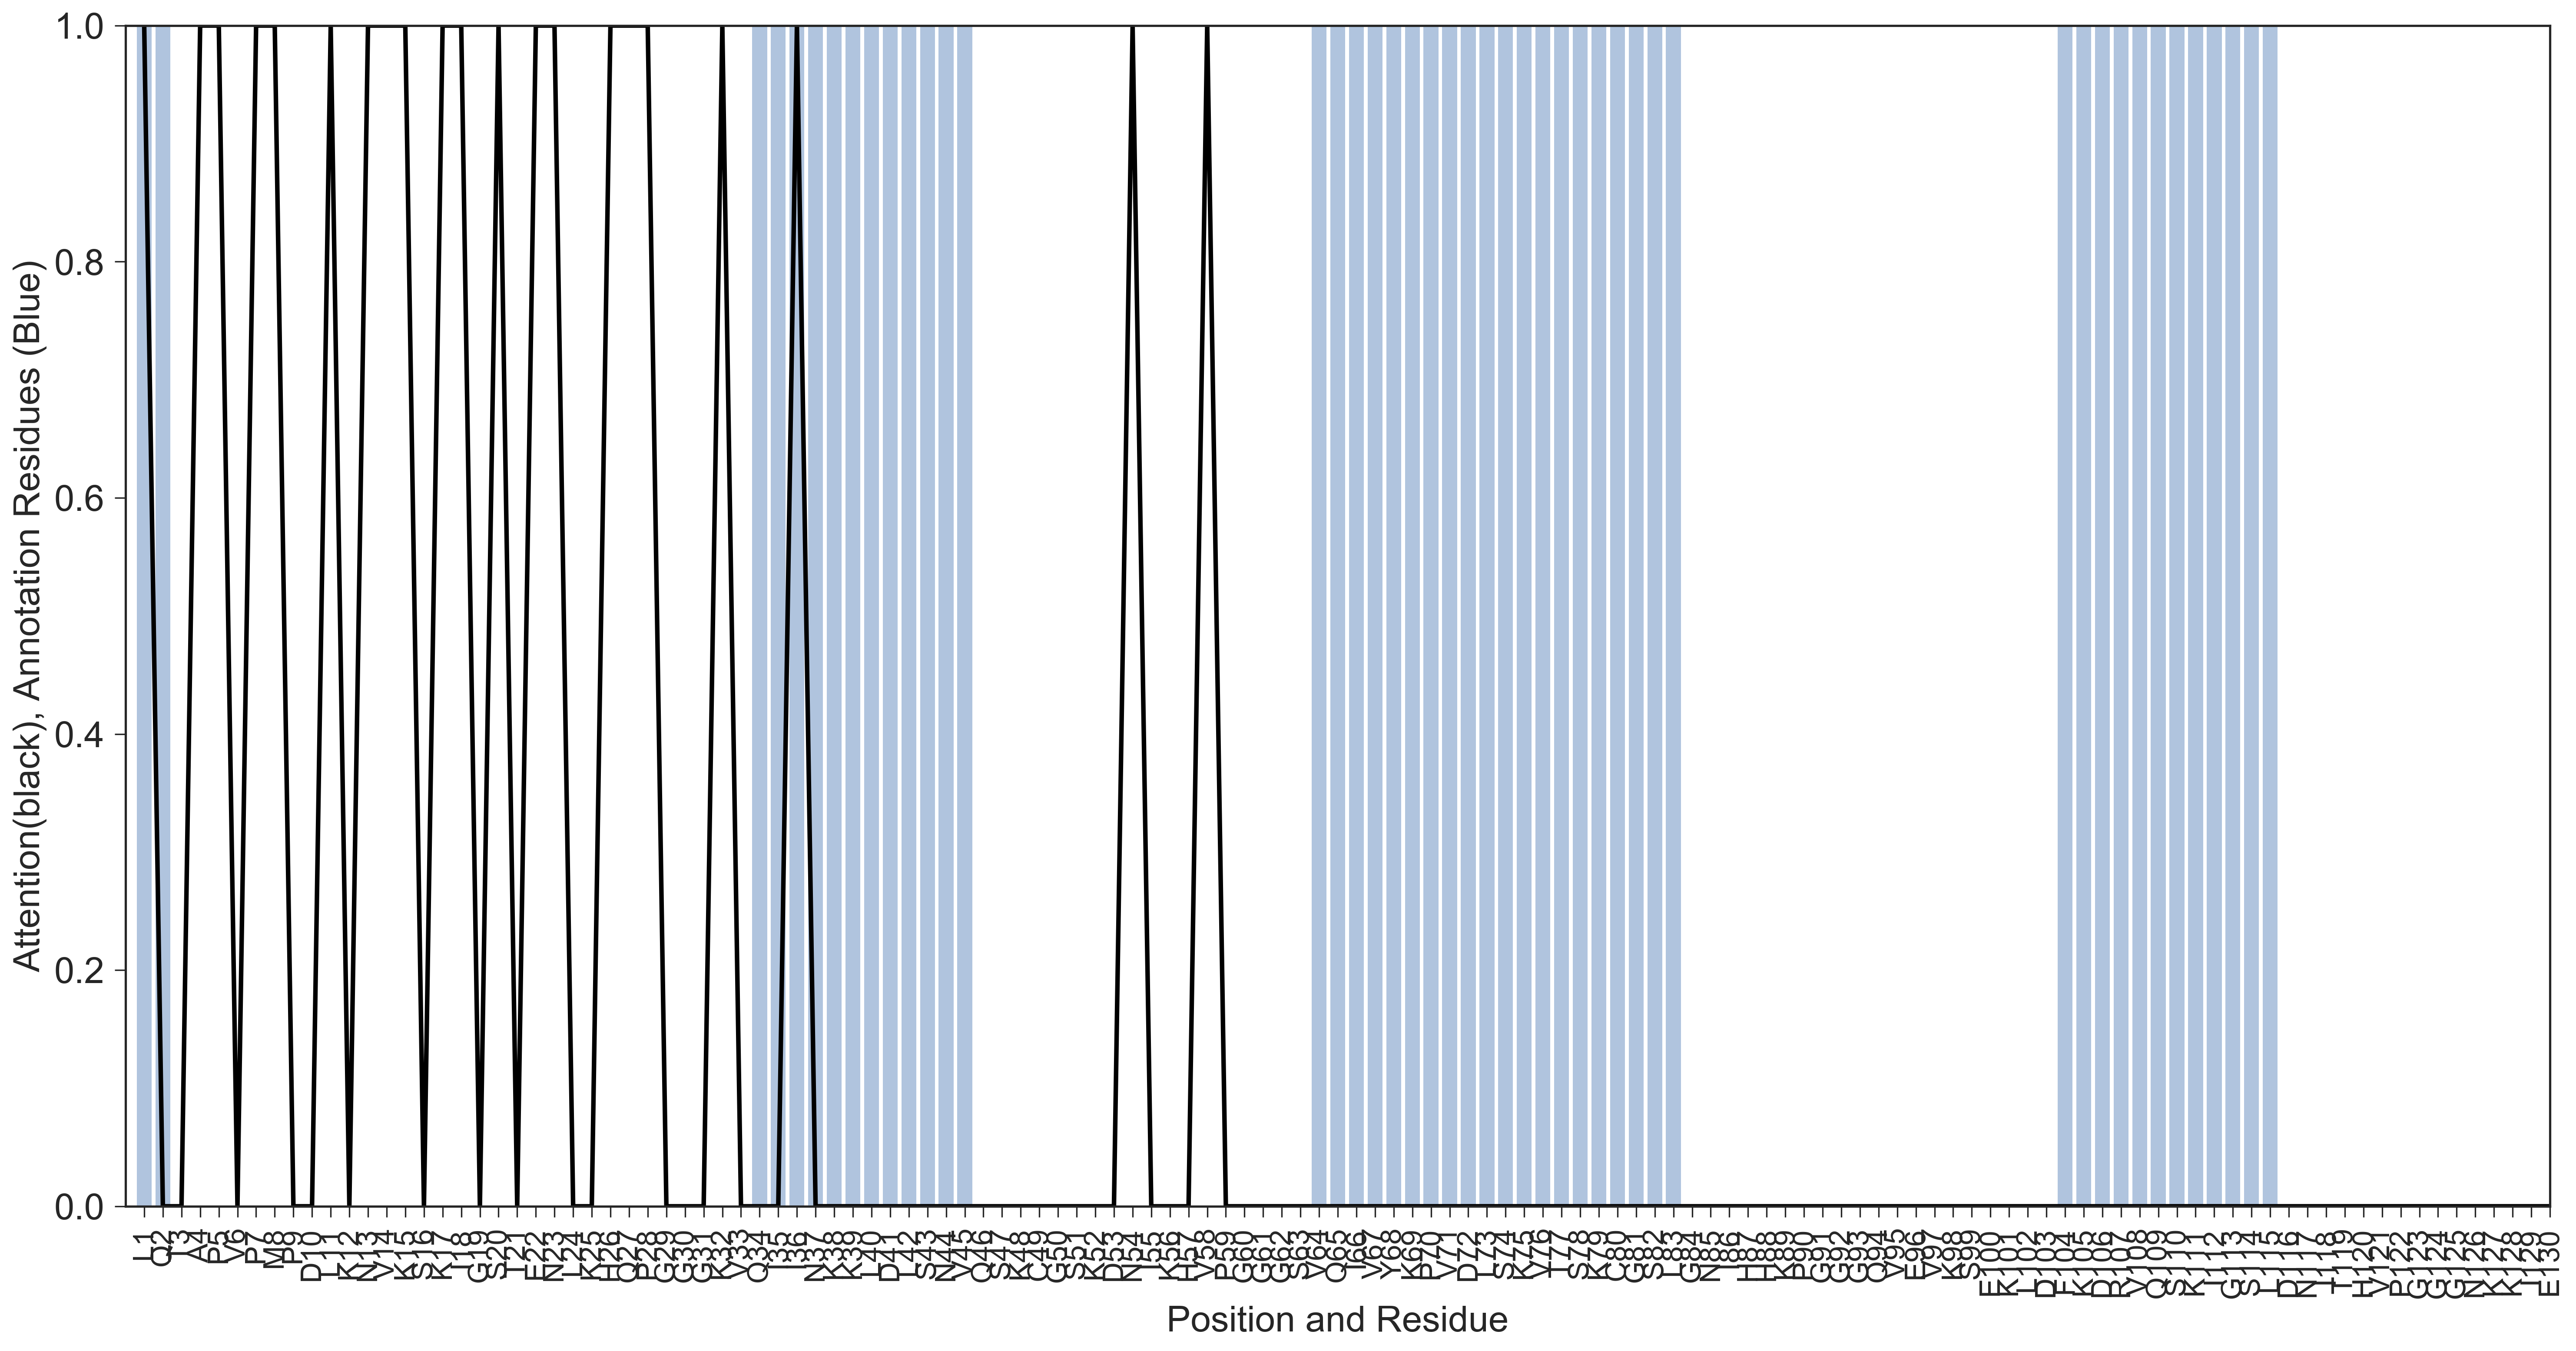

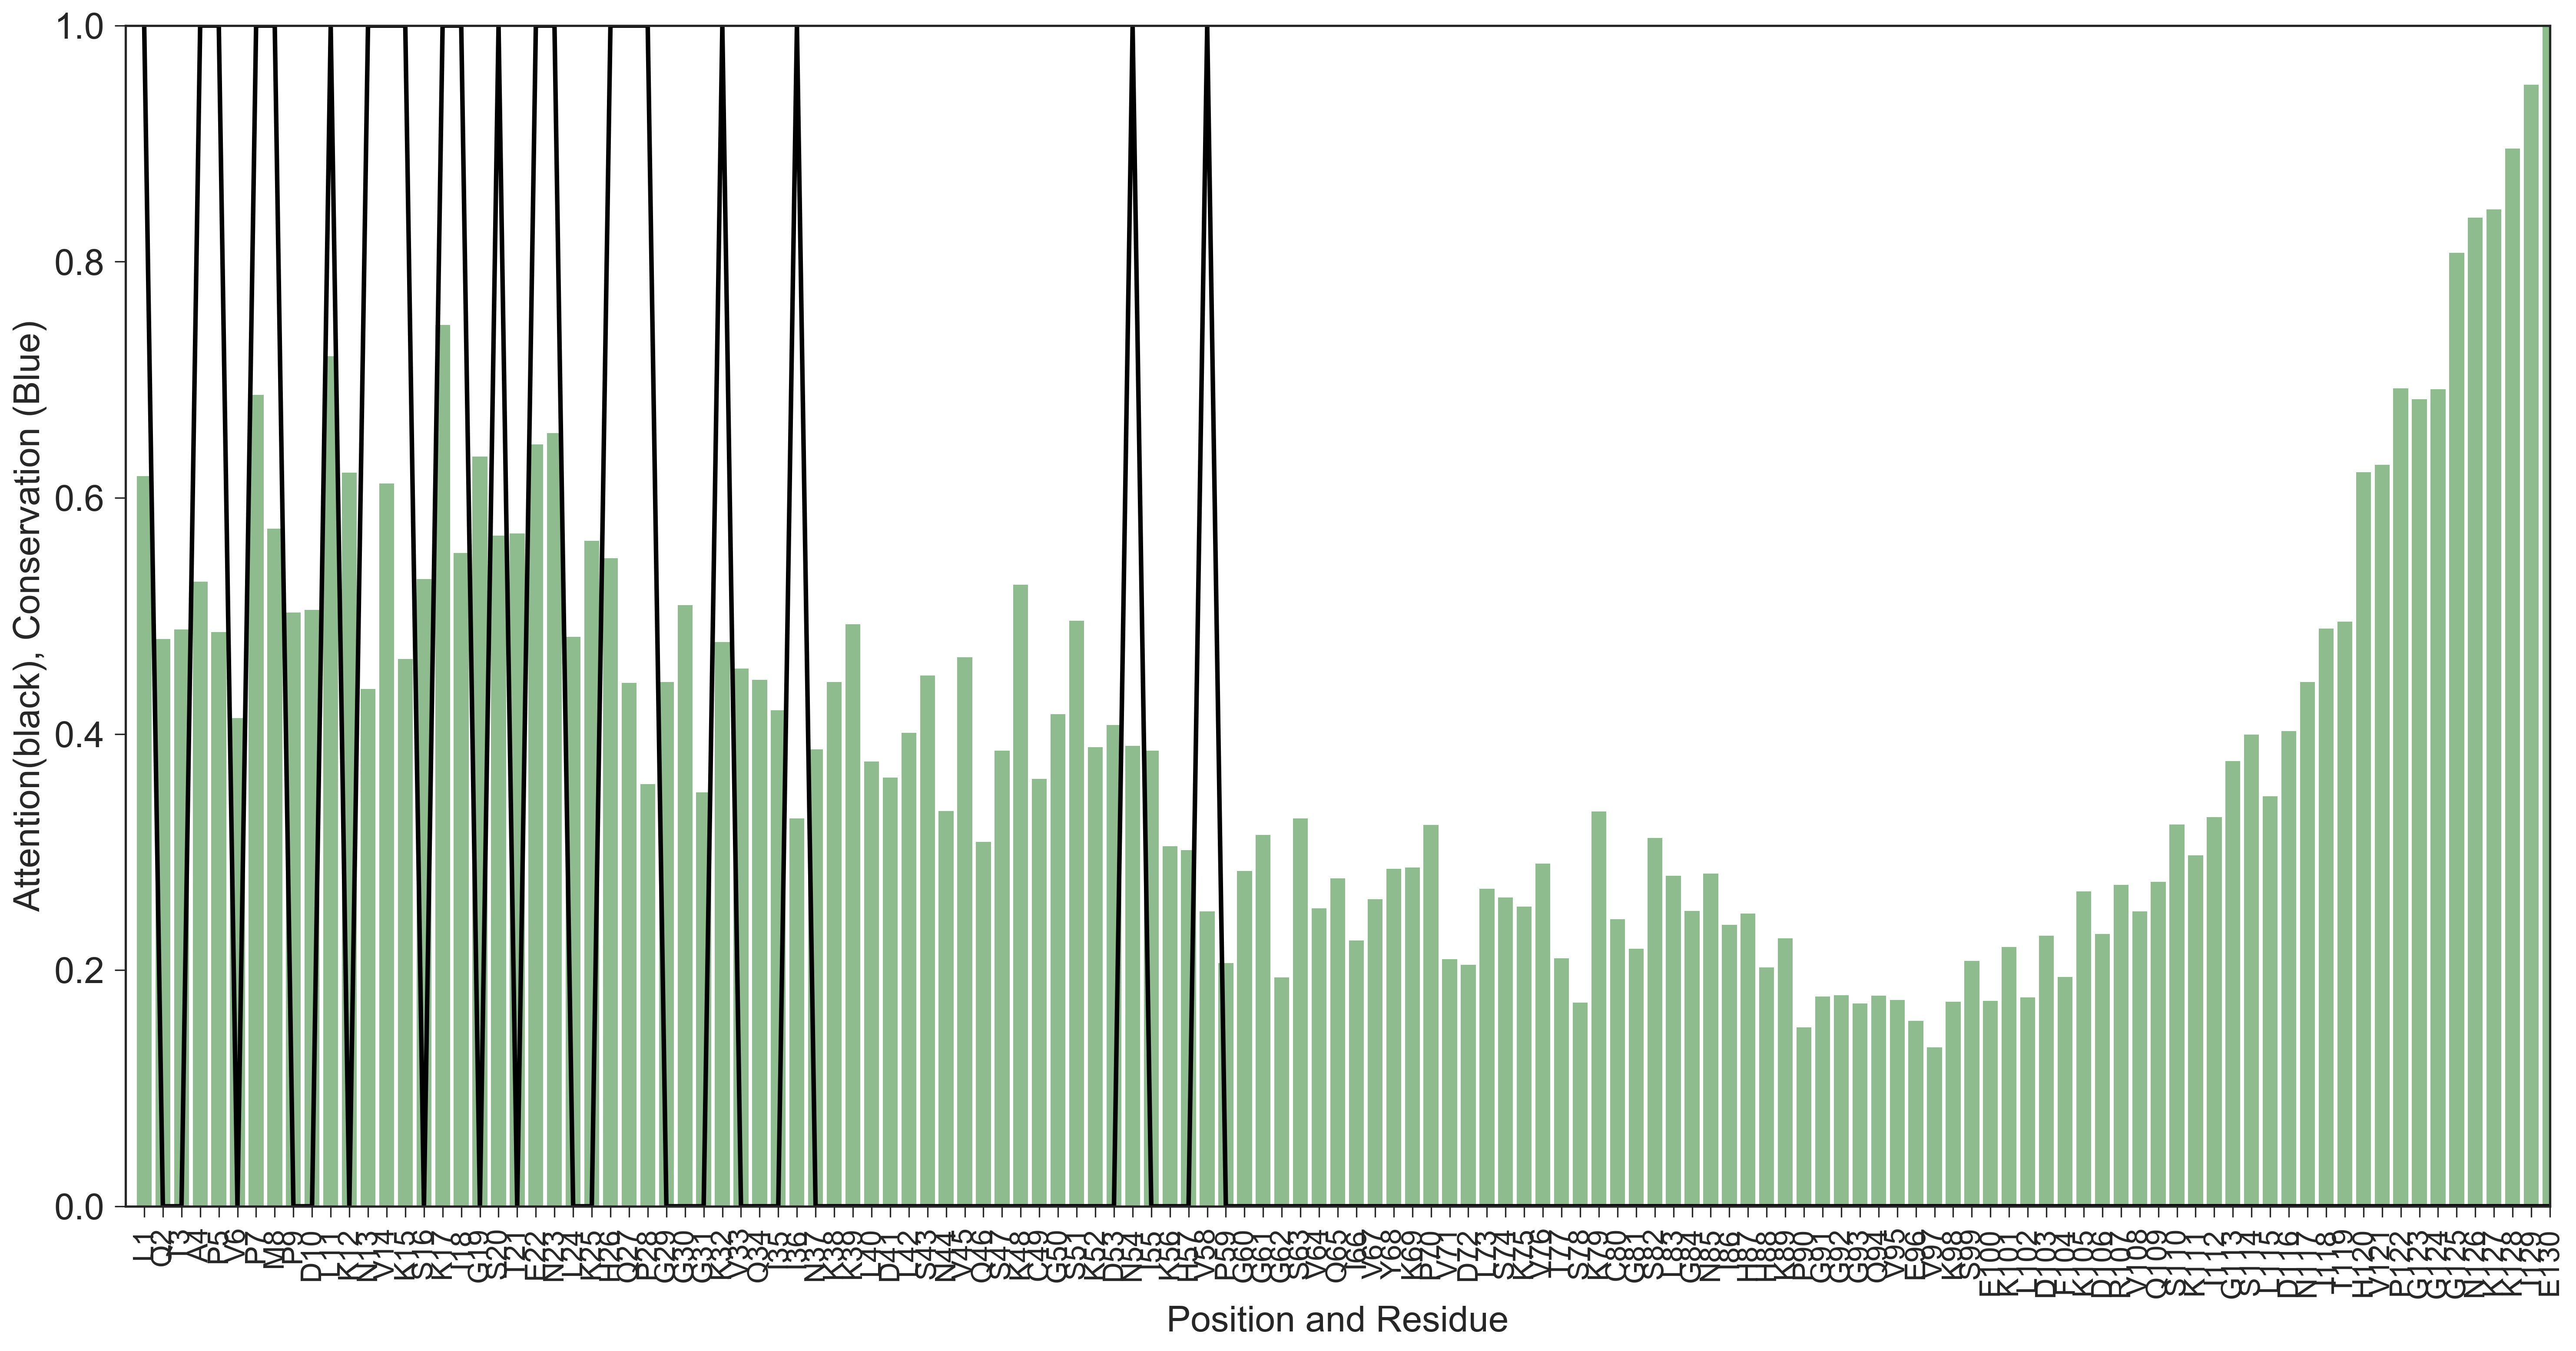

In [15]:
from sklearn import metrics
dataacu=sca_attn

data_auc=metrics.auc(nums, dataacu)
y_auc=metrics.auc(nums, y)
roc_auc = metrics.roc_auc_score(y,numpy.array(dataacu))
from sklearn.metrics import f1_score
f1=f1_score(y,numpy.array(dataacu), average='micro')  
print("F1:",f1,"ROC AUC:",roc_auc)


f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = plt.bar(nums,y, color='lightsteelblue');
ax = seaborn.tsplot(data=dataacu, color='black');
ax.set_ylabel("Attention(black), Annotation Residues (Blue)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = plt.bar(nums,D_glo, color='darkseagreen');
ax = seaborn.tsplot(data=dataacu, color='black');
ax.set_ylabel("Attention(black), Conservation (Blue)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)